# Machine Learning Foundation

## Course 6, Part f: SARIMA and Prophet DEMO


## Learning Outcomes
You should walk away from this notebook with:
1. A practical understanding of Autoregressive Integrated Moving Average (ARIMA) models.
2. Insight into checking fit of model.
3. Learn to create forecasts with ARIMA models in Python.
4. A practical understanding of fbprophet
5. How to check fit of fbprophet model
6. Means of adjusting and improving fbprophet model parameters


# Overview: Time Series Modeling Approaches

In previous lessons, we explored Python implementations of fundamental time series concepts including stationarity, smoothing, trend, seasonality, and autocorrelation, and built two kinds of models: 

  * **MA models**: Specify that the current value of the series depends linearly on the series' mean and a set of prior (observed) white noise error terms.
  * **AR models**: Specify that the current value of the  series depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).

In the current lesson we will review these concepts as well as combine these two model types into three more complicated time series models: ARMA, ARIMA, and SARIMA. We will then explore a different type of Time Series modeling using __[Facebook Prophet](https://facebook.github.io/prophet/https://facebook.github.io/prophet/)__. 

__Installation notes:__

[Prophet holiday issues](https://stackoverflow.com/questions/60145006/cannot-import-name-easter-from-holidays)

To install __[pdarima](https://pypi.org/project/pmdarima/)__ on Anaconda, use:

[conda install -c saravji pdarima](https://anaconda.org/saravji/pmdarima)

In [2]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
# os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)
import warnings
warnings.simplefilter(action='ignore')
import fbprophet
import pmdarima as pm

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

---

# Section 1: Time Series Review

We've covered lots of material in the previous four lessons. Now is a good time to step back and rehash what we've covered. This will help to both solidify concepts and ensure you're ready to tackle ARMA, ARIMA, and SARIMA models.

### Section 1.1: Examples of time series data and modeling:
- Hedge fund prediction of stock and index movements
- Long and short-term weather forecasting
- Business budgeting and trend analysis
- Health vitals monitoring
- Traffic flows and logistic optimization modeling
- Can you think of others?

### Section 1.2: Decomposition
Time series data can often be decomposed into trend, seasonal, and random fluctuation components.

Decomposition

- Trends
    - Up
    - Down
    - Flat
    - Larger trends can be made up of smaller trends
    - There is no defined timeframe for what constitutes a trend as it depends on your goals
- Seasonal Effects
    - Weekend retail sales spikes
    - Holiday shopping
    - Energy requirement changes with annual weather patterns
    - Note: Twitter spikes when news happens are not seasonal because they aren't regular and predictable
- Random Fluctuations
    - The human element
    - Aggregations of small influencers
    - Observation errors
    - The smaller this is in relation to Trend and Seasonal, the better we can predict the future

### Section 1.3: Additive vs Multiplicative
Time series models fall into [two camps](http://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics#HOW%20DO%20I%20KNOW%20WHICH%20DECOMPOSITION):
- Additive
    - Data = Trend + Seasonal + Random
    - What we will be using for our modeling
- Multiplicative
    - Data = Trend x Seasonal x Random
    - As easy to fit as Additive if we take the log
        - log(Data) = log(Trend x Seasonal x Random)

We should use multiplicative models when the percentage change of our data is more important than the absolute value change (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations. If our seasonality and fluctuations are stable, we likely have an additive model.

### Section 1.4: Time Series Modeling Process
Time series model selection is driven by the Trend and Seasonal components of our raw data. The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
    1. Difference or take the log of the data (multiple times if needed) to remove trends for [certain model applications](https://en.wikipedia.org/wiki/Stationary_process)
    1. Stationairity is needed for ARMA models
1. Determine if we have additive or multiplicative data patterns
1. Select the appropriate algorithm based on the chart below
1. Determine if model selection is correct with these tools
    - Ljung-Box Test
    - Residual Errors (Normal Distribution with zero mean and constant variance-homoskedastic, i.i.d)
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |X||
Simple Exponential Smoothing |X||
Seasonal Adjustment |X|X|
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|

### Section 1.5: How to Achieve and Test for Stationarity
- The mean of the series is not a function of time.

- The variance of the series is not a function of time (homoscedasticity).

- The covariance at different lags is not a function of time.

[From A Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

- [Info on stationarity](http://www.investopedia.com/articles/trading/07/stationary.asp)
- Plotting Rolling Statistics
    - Plot the moving average/variance and see if it changes with time. This visual technique can be done on different windows, but isn't as rigorously defensible as the test below.
- Augmented Dickey-Fuller Test
    - Statistical tests for checking stationarity; the null hypothesis is that the TS is non-stationary. If our test statistic is below an `alpha` value, we _can_ reject the null hypothesis and say that the series is stationary.
    
    $$ Y_t = \rho * Y_{t-1} + \epsilon_t $$
    
    $$ Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t $$
    
### Section 1.6: Differencing Example

This will give us a reminder to how differencing is used to get a stationary series which will be essential to the final piece of the ARIMA model

In [3]:
# create a play dataframe from 1-10 (linear and squared) to test how differencing works
play = pd.DataFrame([[x for x in range(1,11)], [x**2 for x in range(1,11)]]).T
play.columns = ['original', 'squared']
play

original  squared
0         1        1
1         2        4
2         3        9
3         4       16
4         5       25
5         6       36
6         7       49
7         8       64
8         9       81
9        10      100

In [4]:
# stationarize linear series (mean and variance don't change for sub-windows)
play.original.diff()

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: original, dtype: float64

Text(0.5, 1.0, 'second diff')

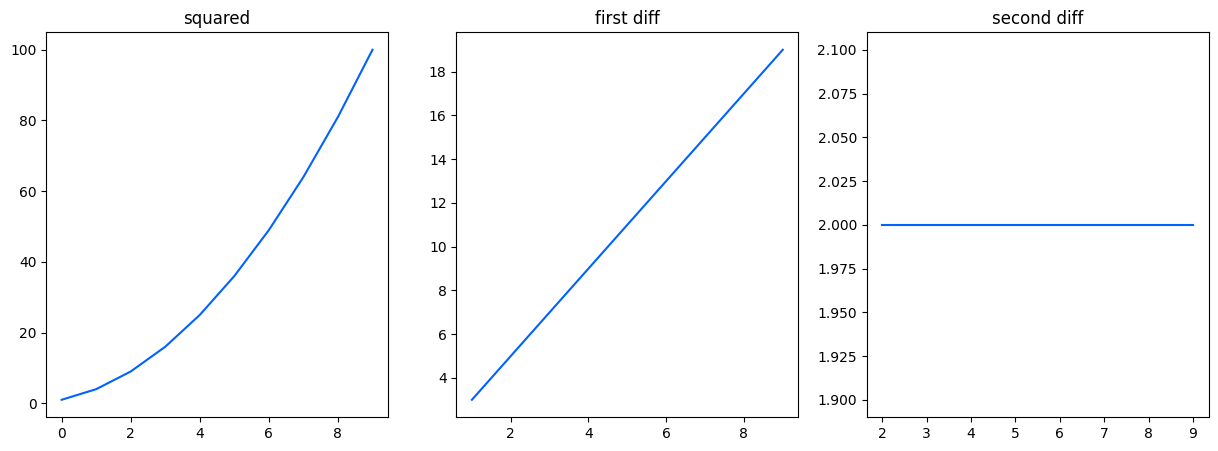

In [5]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
axes[0].plot(play.squared)
axes[0].set_title('squared')
axes[1].plot(play.squared.diff())
axes[1].set_title('first diff')
axes[2].plot(play.squared.diff().diff())
axes[2].set_title('second diff')


**NOTE:** This is similar to taking a first-order derivative.

In [6]:
# stationarize squared series
play.squared.diff().diff()

0    NaN
1    NaN
2    2.0
3    2.0
4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    2.0
Name: squared, dtype: float64

**NOTE:** Notice we need to difference twice on an exponential trend, and every time we do, we lose a bit of data

In [7]:
# stationarize squared with log
np.log(play.squared)

0    0.000000
1    1.386294
2    2.197225
3    2.772589
4    3.218876
5    3.583519
6    3.891820
7    4.158883
8    4.394449
9    4.605170
Name: squared, dtype: float64

**NOTE:** Works somewhat but certainly not as well.

Text(0.5, 1.0, 'log')

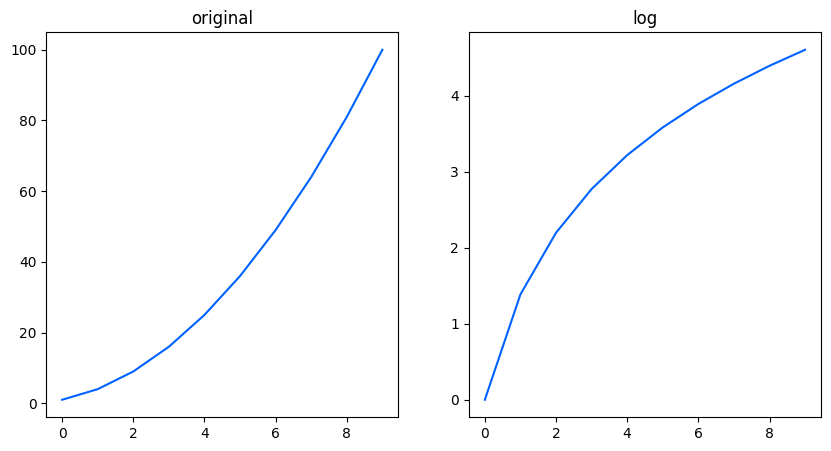

In [8]:
fig,axes = plt.subplots(1,2,figsize = (10,5))
axes[0].plot(play.squared)
axes[0].set_title('original')
axes[1].plot(np.log(play.squared))
axes[1].set_title('log')

## Data Prep and EDA

We'll be looking at [monthly average temperatures between 1907-1972](https://datamarket.com/data/set/22o4/mean-monthly-temperature-1907-1972#!ds=22o4&display=line)

In [9]:
# load data and convert to datetime
monthly_temp = pd.read_csv('./mean-monthly-temperature-1907-19.csv', 
                           skipfooter=2, 
                           infer_datetime_format=True, 
                           header=0, 
                           index_col=0, engine='python',
                           names=['month', 'temp'])

monthly_temp.index = pd.to_datetime(monthly_temp.index)

In [10]:
monthly_temp.head()

temp
month           
1907-01-01  33.3
1907-02-01  46.0
1907-03-01  43.0
1907-04-01  55.0
1907-05-01  51.8

In [11]:
# describe
monthly_temp.describe()

temp
count  792.000000
mean    53.553662
std     15.815452
min     11.200000
25%     39.675000
50%     52.150000
75%     67.200000
max     82.400000

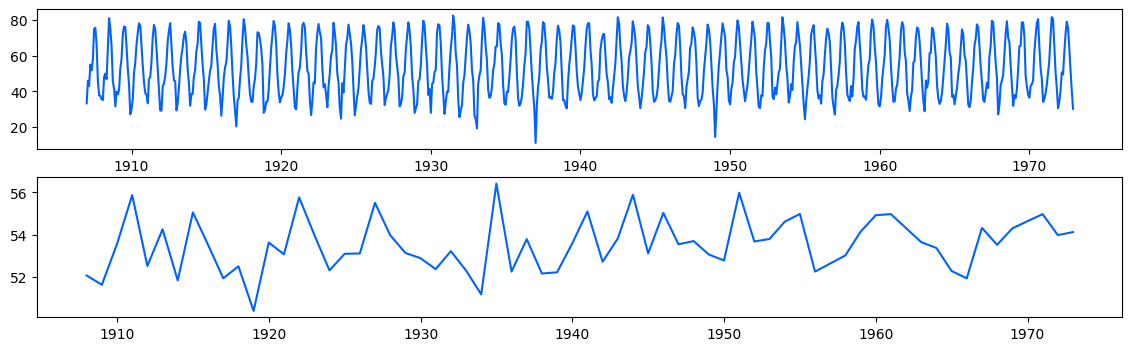

In [12]:
# resample to annual and plot each
plt.rcParams['figure.figsize'] = [14, 4]
annual_temp = monthly_temp.resample('A').mean()
fig, axes = plt.subplots(2,1)
axes[0].plot(monthly_temp)
axes[1].plot(annual_temp)

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

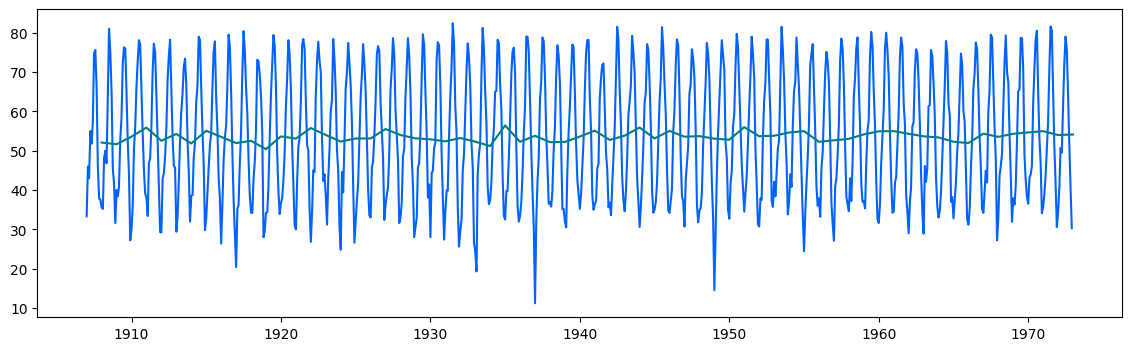

In [13]:
# plot both on same figure
plt.plot(monthly_temp)
plt.plot(annual_temp)
plt.grid(b=True);

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

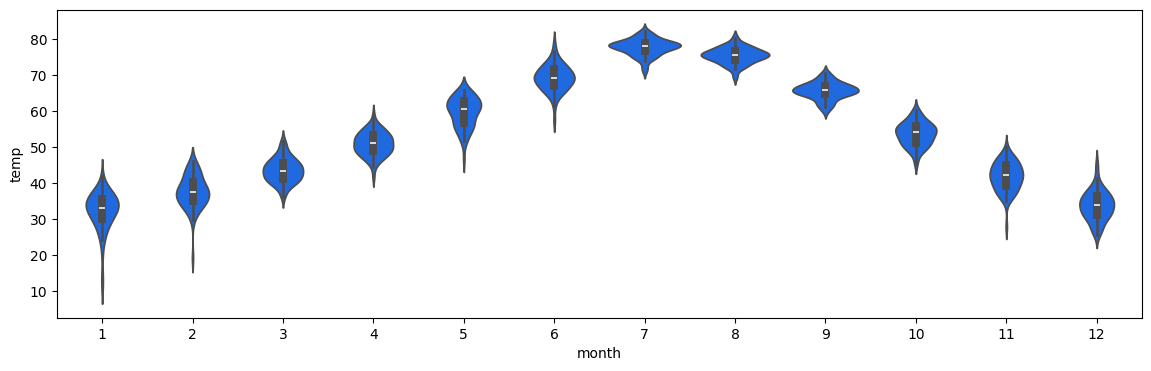

In [14]:
# violinplot of months to determine variance and range
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp)
plt.grid(b=True);

In [15]:
# split data into 10 chunks
chunks = np.split(monthly_temp.temp, indices_or_sections=12)

In [16]:
mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
mean_var

mean_vals    var_vals
0   52.674242  225.907973
1   53.654545  246.031570
2   52.837879  247.400838
3   54.078788  250.787429
4   52.439394  277.865721
5   53.457576  283.619412
6   53.718182  224.882397
7   54.422727  265.442059
8   53.457576  238.561230
9   54.425758  257.425852
10  52.613636  219.026026
11  54.863636  253.827466

In [17]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -6.481466e+00
p-value                 1.291867e-08
Lags Used               2.100000e+01
Observations Used       7.700000e+02
Critical Value (1%)    -3.438871e+00
Critical Value (5%)    -2.865301e+00
Critical Value (10%)   -2.568773e+00
dtype: float64


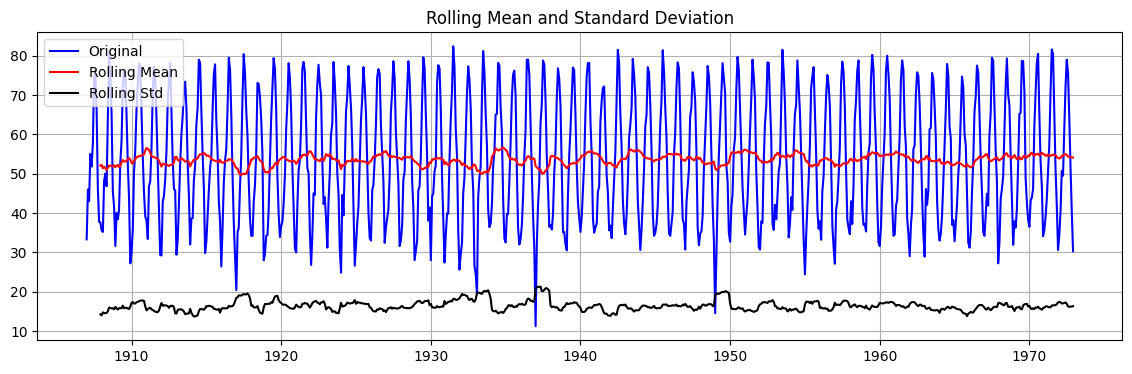

In [18]:
# run DFT on monthly
dftest(monthly_temp.temp)
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -7.878242e+00
p-value                 4.779473e-12
Lags Used               0.000000e+00
Observations Used       6.500000e+01
Critical Value (1%)    -3.535217e+00
Critical Value (5%)    -2.907154e+00
Critical Value (10%)   -2.591103e+00
dtype: float64


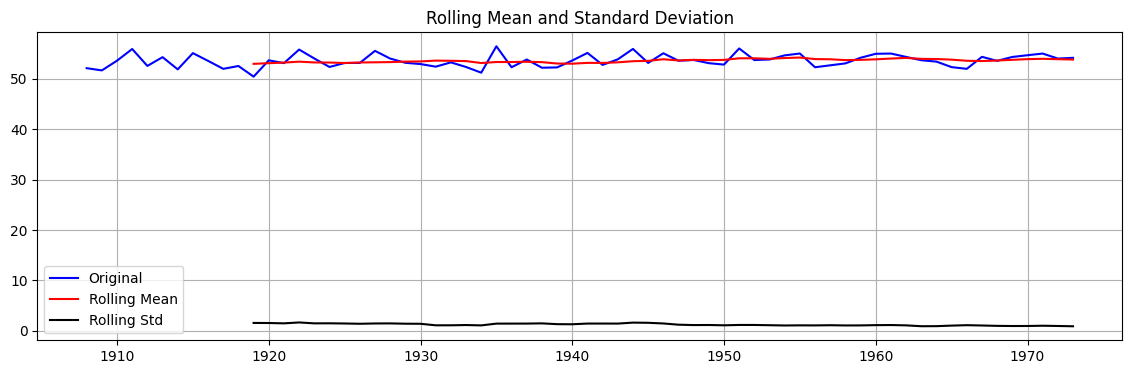

In [19]:
# run DFT on annual
dftest(annual_temp.temp)

The p-value allows us to *reject* a unit root (i.e. the data is stationary).

Test Statistic          -0.449458
p-value                  0.901508
Lags Used               10.000000
Observations Used       55.000000
Critical Value (1%)     -3.555273
Critical Value (5%)     -2.915731
Critical Value (10%)    -2.595670
dtype: float64


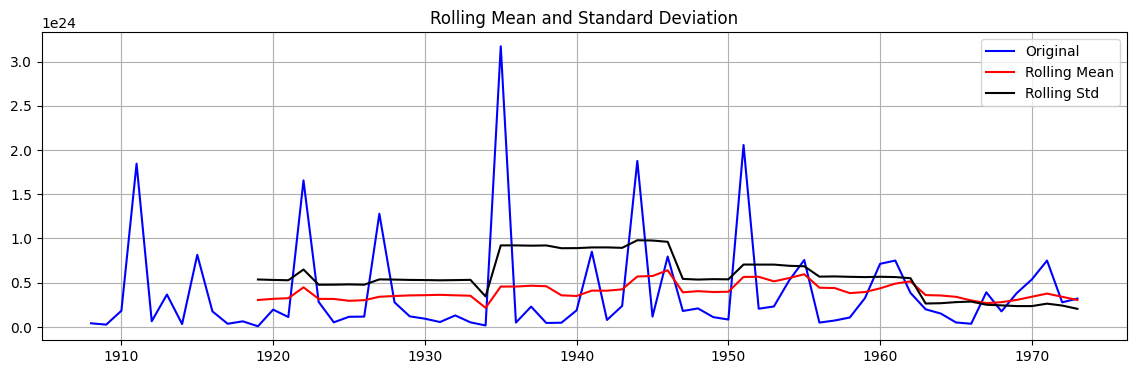

In [20]:
# here's an example of non-stationary with DFT results
dftest(np.exp(annual_temp.temp))

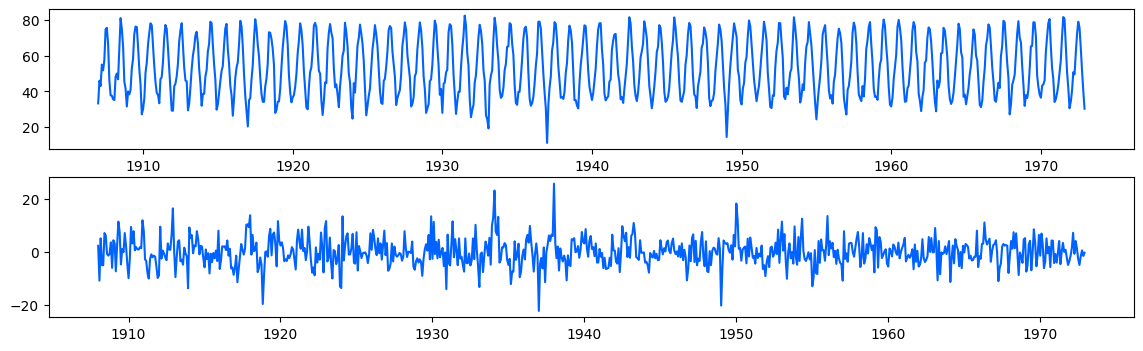

In [21]:
# Important to note that values have strong seasonality and adf test as well as rolling mean may not capture this.
# That is why it is always important to pay attention to run sequence plot
monthly_temp['lag_12'] = monthly_temp.shift(12)
monthly_temp['seasonal_diff'] = monthly_temp.temp - monthly_temp['lag_12']

fig,axes = plt.subplots(2,1)
axes[0].plot(monthly_temp.temp,label ='original')
axes[1].plot(monthly_temp.seasonal_diff,label = 'seasonal diff')

## Section 2: SARIMA with Statsmodels

We went through getting stationary data and differencing as that is the last piece of the puzzle that we are missing for understanding ARIMA models. The I stands for "Integrated" which just refers to the amount of differcing done on the data.

When we are determining our ARIMA model we will come across the following standard inputs:
- order(p,d,q):
    - p is number of AR terms
    - d is number of times that we would difference our data
    - q is number of MA terms
    
When we work with SARIMA models 'S' refers to 'seasonal' and we have the additional standard inputs:
- seasonal order(p,d,q):
    - p is number of AR terms in regards to seasonal lag
    - d is number of times that we would difference our seasonal lag (as seen above)
    - q is number of MA terms in regards to seasonal lag
    - s is number of periods in a season

Reminder of some good resources:
- [ARIMA in R](https://www.otexts.org/fpp/8/5)
- [Duke ARIMA Guide](https://people.duke.edu/~rnau/411arim2.htm)
- [Great explanation on MA in practice](http://stats.stackexchange.com/questions/164824/moving-average-ma-process-numerical-intuition)

Some rules to highlight from the Duke ARIMA Guide:
1. If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing
2. If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING!!
3. A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model)

### Create Helper Functions

In [22]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

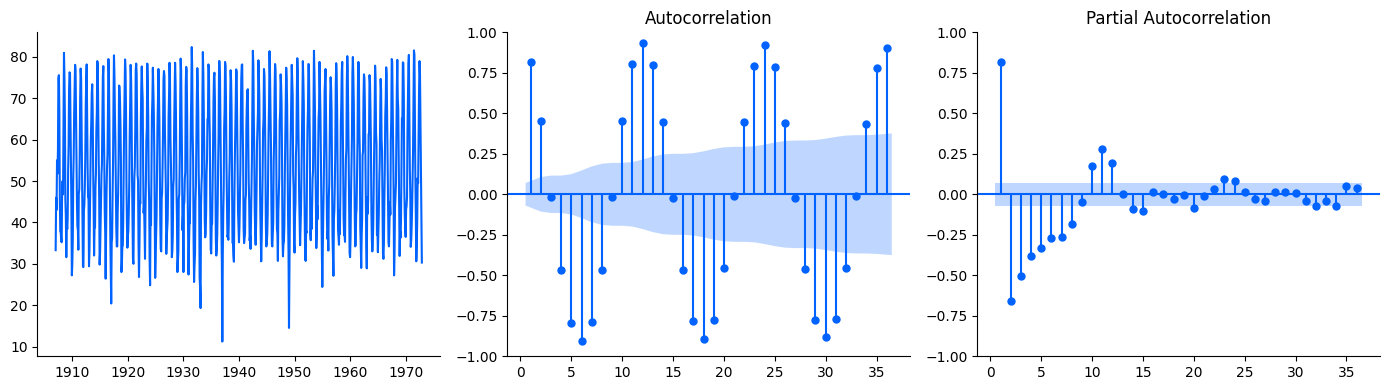

In [23]:
# helper plot for monthly temps
plots(monthly_temp.temp, lags=36);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

In [24]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_temp.temp, 
                                order=(1,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79583D+00    |proj g|=  8.54150D-02


 This problem is unconstrained.



At iterate    5    f=  2.70074D+00    |proj g|=  2.46650D-02

At iterate   10    f=  2.68921D+00    |proj g|=  2.48171D-02

At iterate   15    f=  2.68806D+00    |proj g|=  4.35250D-03

At iterate   20    f=  2.68798D+00    |proj g|=  4.98461D-03

At iterate   25    f=  2.68797D+00    |proj g|=  1.32615D-04

At iterate   30    f=  2.68797D+00    |proj g|=  1.61307D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     39      1     0     0   4.606D-05   2.688D+00
  F =   2.6879709212246019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  792
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -2128.873
Date:                              Tue, 13 Aug 2024   AIC                           4265.746
Time:                                      10:42:22   BIC                           4284.383
Sample:                                  01-01-1907   HQIC                          4272.914
                                       - 12-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0127      0.007      1.698      0.090      -0.002       0.027
ar.L1          0.1791      0.035      5.105      0.000       0.110       0.248
ma.S.L12      -0.9996      1.187     -0.842      0.400      -3.326       1.327
sigma2        12.8926     15.184      0.849      0.396     -16.867      42.653
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               252.77
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.56
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

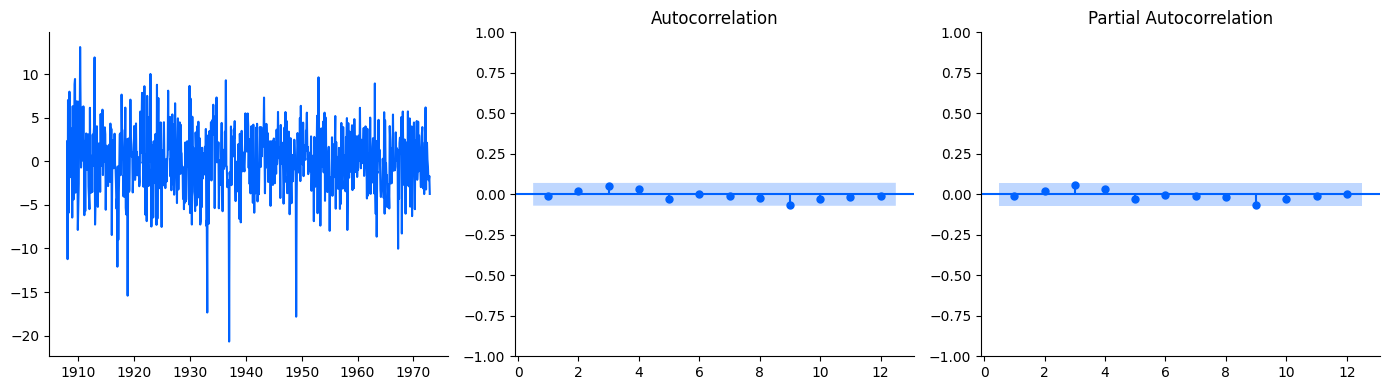

In [25]:
# plot resids
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

**Thought process:**  

010010 is probably overdifferenced as we can see by negative ACF at lag 1

000010 is a big underdiff at seasonal lag, but with better AIC

Looks like 000010,12 and Trend='c' per rule

Looking back at seasonal we notice negative ACR spike at 12: we will thus add a SMA term and we see a big drop in AIC to 4289

looks like ACF looks good at seasonal lags, so we move back to ARIMA portion.

ACF shows we can use AR terms. AR=1,2 or 3 have similar AIC

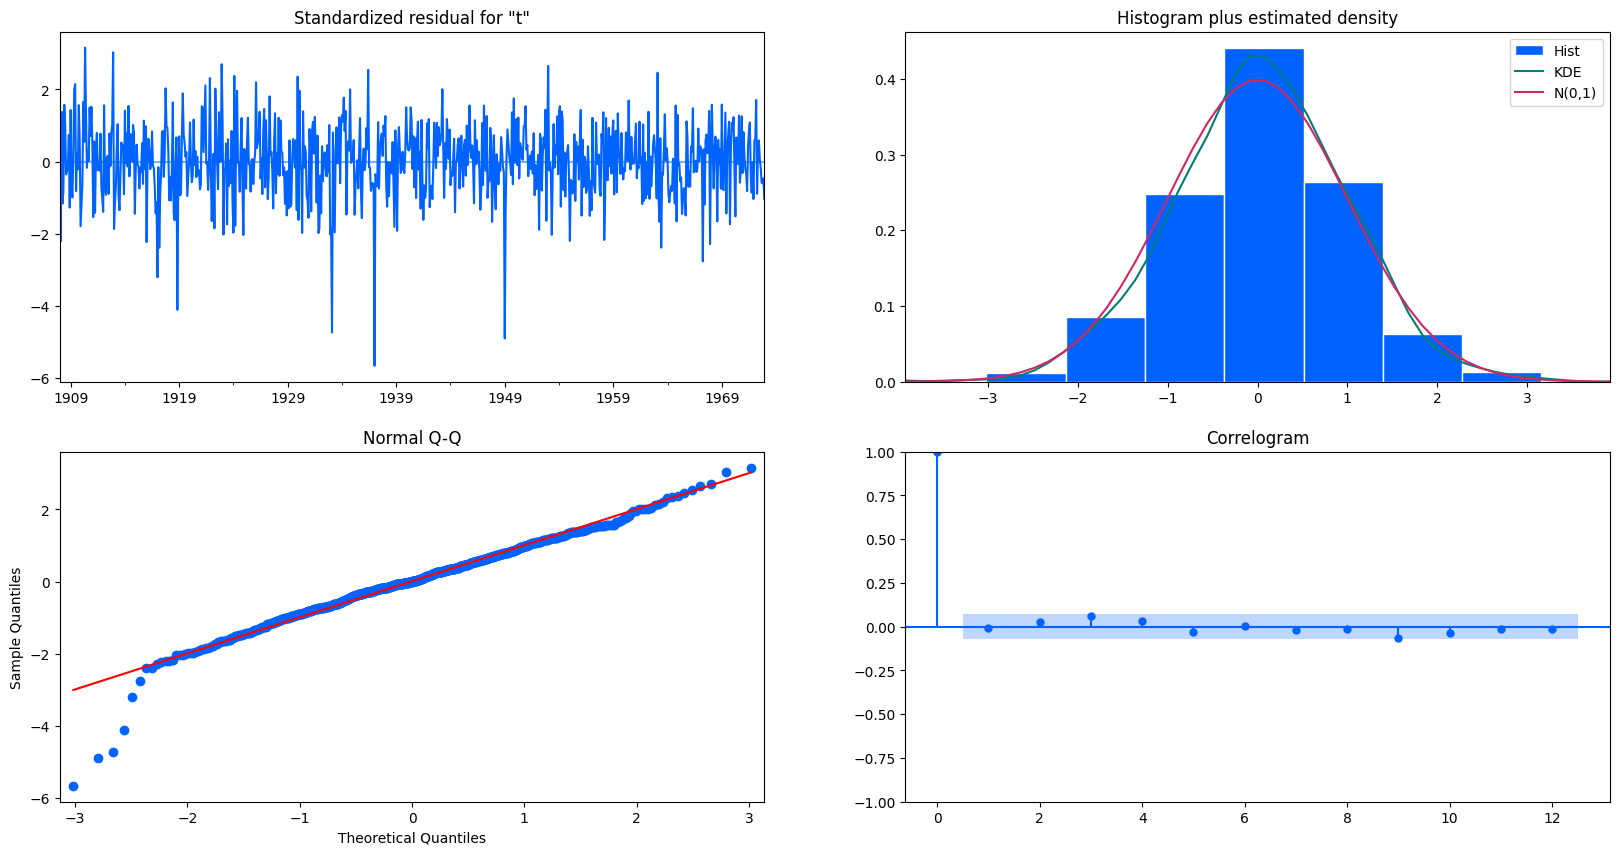

In [26]:
# plot residual diagnostics
sar.plot_diagnostics(lags=12,figsize = (20,10),);

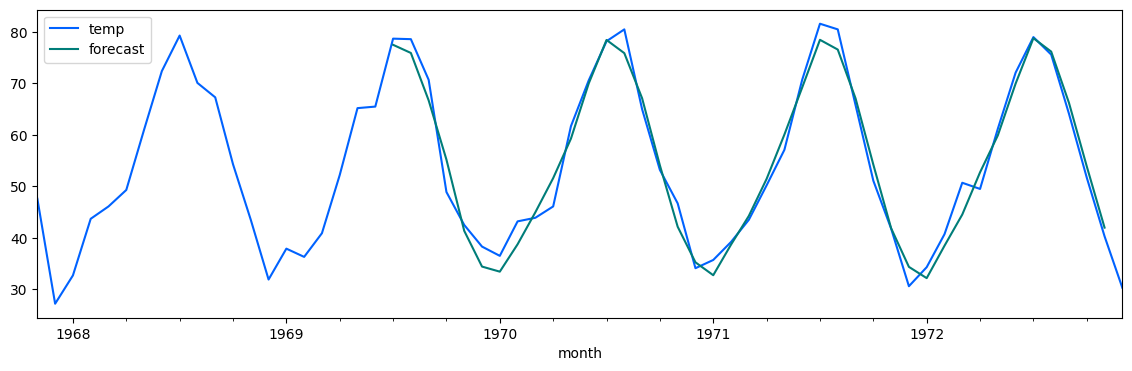

In [27]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
monthly_temp['forecast'] = sar.predict(start = 750, end= 790)  
monthly_temp[730:][['temp', 'forecast']].plot();

In [28]:
monthly_temp.iloc[740:760]

temp  lag_12  seasonal_diff   forecast
month                                             
1968-09-01  67.3    67.5           -0.2        NaN
1968-10-01  54.3    56.1           -1.8        NaN
1968-11-01  43.5    47.6           -4.1        NaN
1968-12-01  31.9    27.2            4.7        NaN
1969-01-01  37.9    32.7            5.2        NaN
1969-02-01  36.3    43.7           -7.4        NaN
1969-03-01  40.9    46.1           -5.2        NaN
1969-04-01  52.2    49.3            2.9        NaN
1969-05-01  65.2    61.0            4.2        NaN
1969-06-01  65.5    72.4           -6.9        NaN
1969-07-01  78.7    79.3           -0.6  77.502906
1969-08-01  78.6    70.1            8.5  75.917853
1969-09-01  70.7    67.3            3.4  66.704977
1969-10-01  48.9    54.3           -5.4  55.189333
1969-11-01  42.5    43.5           -1.0  41.358357
1969-12-01  38.3    31.9            6.4  34.416497
1970-01-01  36.5    37.9           -1.4  33.429892
1970-02-01  43.2    36.3            6.9  38.749190
1970-03-01  43.9    40.9            3.0  44.975953
1970-04-01  46.1    52.2           -6.1  51.596332

In [29]:
#Introducing another model
sar2 = sm.tsa.statespace.SARIMAX(monthly_temp.temp, 
                                order=(3,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79011D+00    |proj g|=  8.49400D-02

At iterate    5    f=  2.69882D+00    |proj g|=  2.04038D-02

At iterate   10    f=  2.68676D+00    |proj g|=  8.39736D-03

At iterate   15    f=  2.68570D+00    |proj g|=  1.03361D-02

At iterate   20    f=  2.68559D+00    |proj g|=  4.79821D-03

At iterate   25    f=  2.68557D+00    |proj g|=  8.90839D-04

At iterate   30    f=  2.68557D+00    |proj g|=  7.14106D-04

At iterate   35    f=  2.68557D+00    |proj g|=  1.11407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

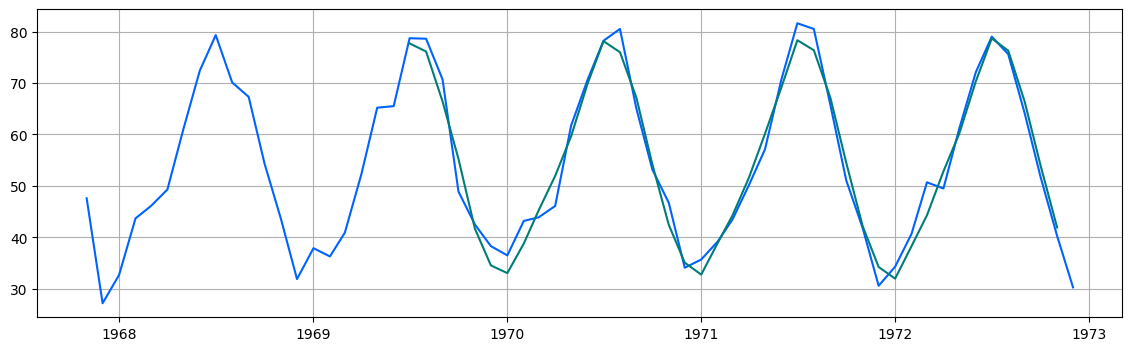

In [30]:
# plot predictions
monthly_temp['forecast'] = sar2.predict(start = 750, end= 790, dynamic=False)  
plt.plot(monthly_temp[730:][['temp', 'forecast']])
plt.grid();

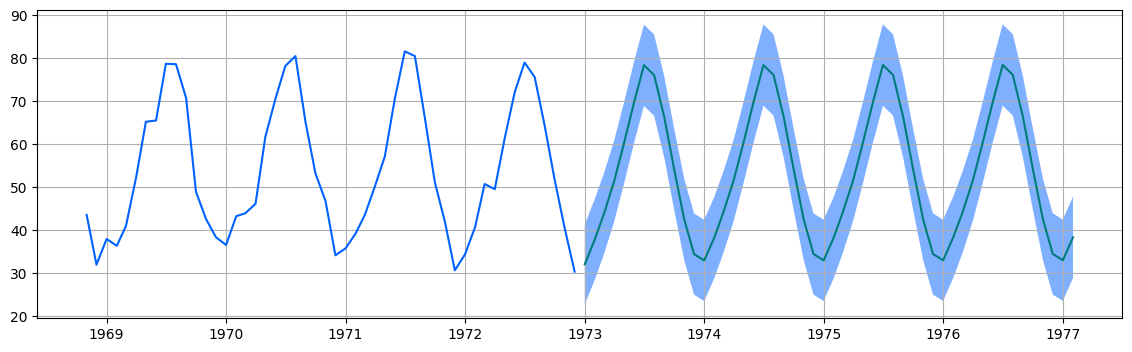

In [31]:
# can use get forecast to create a forecast object
future_fcst = sar2.get_forecast(50)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
# Has an attribute to pull in predicted mean
fcst = future_fcst.predicted_mean
# Plot predictions and confidence intervals
plt.plot(monthly_temp.temp[-50:])
plt.plot(fcst)
plt.fill_between(confidence_int.index,confidence_int['lower temp'],confidence_int['upper temp'],alpha = 0.5)
plt.grid()

## Section 3: Statistical Tests


- [Normality (Jarque-Bera)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality)
    - Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)

- [Serial correlation (Ljung-Box)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation)
    - Null hypothesis is no serial correlation in residuals (independent of each other)

- [Heteroskedasticity](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity)
    - Tests for change in variance between residuals.
    - The null hypothesis is no heteroskedasticity. That means different things depending on which alternative is selected:
        - Increasing: Null hypothesis is that the variance is not increasing throughout the sample; that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.
        - Decreasing: Null hypothesis is that the variance is not decreasing throughout the sample; that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample.
        - Two-sided (default): Null hypothesis is that the variance is not changing throughout the sample. Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

- [Durbin Watson](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)
    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)

In [32]:
sar.test_normality?

Signature: sar.test_normality(method)
Docstring:
Test for normality of standardized residuals.

Null hypothesis is normality.

Parameters
----------
method : {'jarquebera', None}
    The statistical test for normality. Must be 'jarquebera' for
    Jarque-Bera normality test. If None, an attempt is made to select
    an appropriate test.

See Also
--------
statsmodels.stats.stattools.jarque_bera
    The Jarque-Bera test of normality.

Notes
-----
Let `d` = max(loglikelihood_burn, nobs_diffuse); this test is
calculated ignoring the first `d` residuals.

In the case of missing data, the maintained hypothesis is that the
data are missing completely at random. This test is then run on the
standardized residuals excluding those corresponding to missing
observations.
File:      ~/miniconda3/envs/trainee/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py
Type:      method

In [33]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=252.770, p=0.000
Ljung-Box: val=15.499, p=0.905
Heteroskedasticity: val=0.708, p=0.006
Durbin-Watson: d=2.01


### Note on autofit methods
R has an autoARIMA function (and other automagic methods) that gridsearches/optimizes our model hyperparameters for us. Over time, more of these goodies are porting to Python (e.g. pmdarima). While there's nothing wrong with utilizing these resources, the _human makes the final determination!_ Don't become over-reliant on these methods, especially early on when you are grasping the underlying mechanics and theory!

In [34]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(monthly_temp.temp, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4796.839, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4546.179, Time=1.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4794.867, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4769.737, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4451.142, Time=2.74 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.47 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.98 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4477.926, Time=2.62 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4452.084, Time=3.45 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4450.271, Time=4.99 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4545.537, Time=1.92 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=15.35 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=

In [35]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

In [36]:
preds = future_preds_df(stepwise_model,monthly_temp.temp,100)

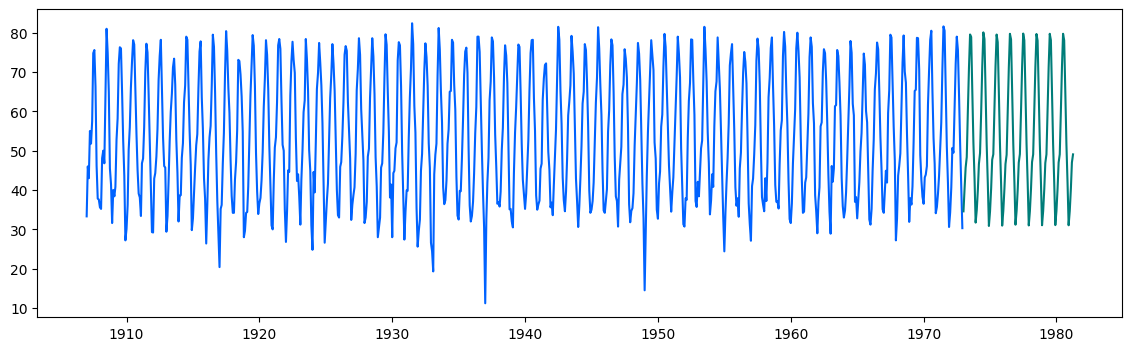

In [37]:
plt.plot(monthly_temp.temp)
plt.plot(preds)

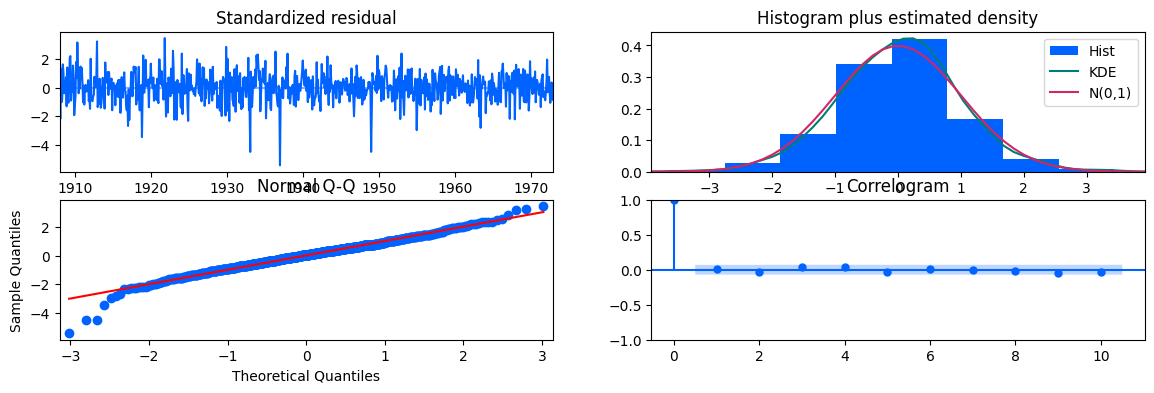

In [38]:
stepwise_model.plot_diagnostics();

In [39]:
print('auto-fit order: :', stepwise_model.order)
print('auto-fit seasonal_order: :', stepwise_model.seasonal_order)

auto-fit order: : (1, 0, 1)
auto-fit seasonal_order: : (2, 1, 0, 12)


When deciding on a model, often what truly matters is how well we would be able to produce out of sample predictions.
Here we create a function that looks at multiple out of sample predictions to see which model had lowest out of sample error

In [40]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [41]:
warnings.filterwarnings("ignore")
series = monthly_temp.temp
horizon = 12
start = 700
step_size = 3
order = (1,0,0)
seasonal_order = (0,1,1,12)

cv1 = cross_validate(monthly_temp.temp,12,700,3,
                    order = order,
                    seasonal_order = seasonal_order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80724D+00    |proj g|=  8.49546D-02


 This problem is unconstrained.



At iterate    5    f=  2.70580D+00    |proj g|=  2.17165D-02

At iterate   10    f=  2.70018D+00    |proj g|=  2.23203D-04

At iterate   15    f=  2.70015D+00    |proj g|=  5.59046D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   5.590D-06   2.700D+00
  F =   2.7001548358591623     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80602D+00    |proj g|=  8.49729D-02


 This problem is unconstrained.



At iterate    5    f=  2.70298D+00    |proj g|=  1.46672D-02

At iterate   10    f=  2.69948D+00    |proj g|=  7.68151D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   1.167D-05   2.699D+00
  F =   2.6994658991114364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80610D+00    |proj g|=  8.49370D-02


 This problem is unconstrained.



At iterate    5    f=  2.70202D+00    |proj g|=  6.36405D-03

At iterate   10    f=  2.70013D+00    |proj g|=  2.88070D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   6.295D-06   2.700D+00
  F =   2.7001287322063945     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80541D+00    |proj g|=  8.51029D-02


 This problem is unconstrained.



At iterate    5    f=  2.70113D+00    |proj g|=  5.60202D-03

At iterate   10    f=  2.69873D+00    |proj g|=  1.56874D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   6.825D-06   2.699D+00
  F =   2.6987195859492537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80644D+00    |proj g|=  8.51664D-02


 This problem is unconstrained.



At iterate    5    f=  2.70140D+00    |proj g|=  6.48211D-03

At iterate   10    f=  2.69875D+00    |proj g|=  1.10673D-04

At iterate   15    f=  2.69873D+00    |proj g|=  4.52274D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   4.523D-06   2.699D+00
  F =   2.6987335158672345     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80475D+00    |proj g|=  8.54224D-02


 This problem is unconstrained.



At iterate    5    f=  2.69981D+00    |proj g|=  7.97514D-03

At iterate   10    f=  2.69680D+00    |proj g|=  4.70113D-04

At iterate   15    f=  2.69678D+00    |proj g|=  2.26832D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   2.268D-05   2.697D+00
  F =   2.6967801772168052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80418D+00    |proj g|=  8.53955D-02


 This problem is unconstrained.



At iterate    5    f=  2.70048D+00    |proj g|=  1.91263D-02

At iterate   10    f=  2.69563D+00    |proj g|=  2.18552D-04

At iterate   15    f=  2.69558D+00    |proj g|=  2.76489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   7.117D-07   2.696D+00
  F =   2.6955836788548746     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80273D+00    |proj g|=  8.56065D-02


 This problem is unconstrained.



At iterate    5    f=  2.69962D+00    |proj g|=  2.15128D-02

At iterate   10    f=  2.69398D+00    |proj g|=  2.50762D-04

At iterate   15    f=  2.69392D+00    |proj g|=  1.87165D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   1.872D-05   2.694D+00
  F =   2.6939196535596426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80457D+00    |proj g|=  8.54106D-02


 This problem is unconstrained.



At iterate    5    f=  2.70711D+00    |proj g|=  1.86571D-02

At iterate   10    f=  2.69733D+00    |proj g|=  2.00267D-03

At iterate   15    f=  2.69703D+00    |proj g|=  1.90113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   5.206D-06   2.697D+00
  F =   2.6970270582733602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80370D+00    |proj g|=  8.53845D-02


 This problem is unconstrained.



At iterate    5    f=  2.70678D+00    |proj g|=  1.86771D-02

At iterate   10    f=  2.69691D+00    |proj g|=  7.31642D-04

At iterate   15    f=  2.69665D+00    |proj g|=  1.62927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   2.084D-06   2.697D+00
  F =   2.6966498545593720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80325D+00    |proj g|=  8.50384D-02


 This problem is unconstrained.



At iterate    5    f=  2.70647D+00    |proj g|=  1.85772D-02

At iterate   10    f=  2.69664D+00    |proj g|=  6.67497D-04

At iterate   15    f=  2.69642D+00    |proj g|=  1.10085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   2.459D-06   2.696D+00
  F =   2.6964171486362023     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80552D+00    |proj g|=  8.42582D-02


 This problem is unconstrained.



At iterate    5    f=  2.70980D+00    |proj g|=  1.84425D-02

At iterate   10    f=  2.70003D+00    |proj g|=  9.43576D-04

At iterate   15    f=  2.69980D+00    |proj g|=  9.72290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   2.775D-07   2.700D+00
  F =   2.6997985466333665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80440D+00    |proj g|=  8.45281D-02


 This problem is unconstrained.



At iterate    5    f=  2.70844D+00    |proj g|=  1.84823D-02

At iterate   10    f=  2.69860D+00    |proj g|=  1.34617D-03

At iterate   15    f=  2.69836D+00    |proj g|=  1.49910D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   3.639D-06   2.698D+00
  F =   2.6983553788077344     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80511D+00    |proj g|=  8.46518D-02


 This problem is unconstrained.



At iterate    5    f=  2.70867D+00    |proj g|=  1.85551D-02

At iterate   10    f=  2.69874D+00    |proj g|=  1.38744D-03

At iterate   15    f=  2.69848D+00    |proj g|=  1.86201D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   8.562D-06   2.698D+00
  F =   2.6984780844744600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80393D+00    |proj g|=  8.47037D-02


 This problem is unconstrained.



At iterate    5    f=  2.70722D+00    |proj g|=  1.85497D-02

At iterate   10    f=  2.69724D+00    |proj g|=  1.21697D-03

At iterate   15    f=  2.69700D+00    |proj g|=  3.10513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   1.955D-06   2.697D+00
  F =   2.6969990739871279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80473D+00    |proj g|=  8.47440D-02


 This problem is unconstrained.



At iterate    5    f=  2.70789D+00    |proj g|=  1.85443D-02

At iterate   10    f=  2.69780D+00    |proj g|=  1.08885D-03

At iterate   15    f=  2.69754D+00    |proj g|=  2.81858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   7.953D-06   2.698D+00
  F =   2.6975342379084037     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80431D+00    |proj g|=  8.46916D-02


 This problem is unconstrained.



At iterate    5    f=  2.70760D+00    |proj g|=  1.86042D-02

At iterate   10    f=  2.69759D+00    |proj g|=  1.03234D-03

At iterate   15    f=  2.69739D+00    |proj g|=  1.17513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   8.877D-08   2.697D+00
  F =   2.6973844348169398     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80441D+00    |proj g|=  8.51515D-02


 This problem is unconstrained.



At iterate    5    f=  2.70751D+00    |proj g|=  1.87245D-02

At iterate   10    f=  2.69745D+00    |proj g|=  1.20494D-03

At iterate   15    f=  2.69723D+00    |proj g|=  1.18884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   4.757D-06   2.697D+00
  F =   2.6972283258913285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80550D+00    |proj g|=  8.44449D-02


 This problem is unconstrained.



At iterate    5    f=  2.70888D+00    |proj g|=  1.83528D-02

At iterate   10    f=  2.69846D+00    |proj g|=  5.51140D-04

At iterate   15    f=  2.69820D+00    |proj g|=  1.34250D-03

At iterate   20    f=  2.69820D+00    |proj g|=  1.29265D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   1.293D-05   2.698D+00
  F =   2.6981971191399485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.70942D+00    |proj g|=  1.88818D-02

At iterate   10    f=  2.69913D+00    |proj g|=  9.14288D-04

At iterate   15    f=  2.69888D+00    |proj g|=  9.08420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   5.814D-07   2.699D+00
  F =   2.6988786313905537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80498D+00    |proj g|=  8.47324D-02


 This problem is unconstrained.



At iterate    5    f=  2.70878D+00    |proj g|=  1.86079D-02

At iterate   10    f=  2.69882D+00    |proj g|=  1.18983D-03

At iterate   15    f=  2.69862D+00    |proj g|=  1.62046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   1.604D-05   2.699D+00
  F =   2.6986192071674231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80439D+00    |proj g|=  8.47192D-02


 This problem is unconstrained.



At iterate    5    f=  2.70831D+00    |proj g|=  1.87578D-02

At iterate   10    f=  2.69824D+00    |proj g|=  1.13506D-03

At iterate   15    f=  2.69802D+00    |proj g|=  4.27452D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   8.608D-06   2.698D+00
  F =   2.6980155029775723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80375D+00    |proj g|=  8.50159D-02


 This problem is unconstrained.



At iterate    5    f=  2.70782D+00    |proj g|=  1.86705D-02

At iterate   10    f=  2.69775D+00    |proj g|=  1.06984D-03

At iterate   15    f=  2.69750D+00    |proj g|=  5.42658D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   5.979D-06   2.698D+00
  F =   2.6975035122100413     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80249D+00    |proj g|=  8.52656D-02


 This problem is unconstrained.



At iterate    5    f=  2.70638D+00    |proj g|=  1.86387D-02

At iterate   10    f=  2.69644D+00    |proj g|=  1.13487D-03

At iterate   15    f=  2.69621D+00    |proj g|=  1.17292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   1.385D-05   2.696D+00
  F =   2.6962127876627537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80167D+00    |proj g|=  8.53951D-02


 This problem is unconstrained.



At iterate    5    f=  2.70503D+00    |proj g|=  1.87050D-02

At iterate   10    f=  2.69498D+00    |proj g|=  1.03643D-03

At iterate   15    f=  2.69473D+00    |proj g|=  1.15044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   1.552D-05   2.695D+00
  F =   2.6947251768579195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80101D+00    |proj g|=  8.51957D-02


 This problem is unconstrained.



At iterate    5    f=  2.70472D+00    |proj g|=  1.84608D-02

At iterate   10    f=  2.69469D+00    |proj g|=  1.14851D-03

At iterate   15    f=  2.69453D+00    |proj g|=  1.49438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   8.642D-06   2.695D+00
  F =   2.6945295513497101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79983D+00    |proj g|=  8.53196D-02


 This problem is unconstrained.



At iterate    5    f=  2.70362D+00    |proj g|=  1.86393D-02

At iterate   10    f=  2.69341D+00    |proj g|=  7.32950D-04

At iterate   15    f=  2.69313D+00    |proj g|=  1.23264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   2.438D-06   2.693D+00
  F =   2.6931261401039261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [42]:
#example to see underpinning of cv


model = sm.tsa.statespace.SARIMAX(series[:701], #only using data through start of 700
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=None).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80724D+00    |proj g|=  8.49546D-02


 This problem is unconstrained.



At iterate    5    f=  2.70580D+00    |proj g|=  2.17165D-02

At iterate   10    f=  2.70018D+00    |proj g|=  2.23203D-04

At iterate   15    f=  2.70015D+00    |proj g|=  5.59046D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   5.590D-06   2.700D+00
  F =   2.7001548358591623     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [43]:
#end of input
series[:701].tail()

month
1965-01-01    32.8
1965-02-01    37.8
1965-03-01    42.0
1965-04-01    49.8
1965-05-01    54.5
Name: temp, dtype: float64

In [44]:
#value to predict horizon steps into the future
series[712:713]

month
1966-05-01    65.6
Name: temp, dtype: float64

In [45]:
# what model predicted for that date
model.forecast(12)[-1:]

1966-05-01    59.580987
Freq: MS, Name: predicted_mean, dtype: float64

In [46]:
cv1.head()

fcst  actual
1966-05-01  59.580987    65.6
1966-08-01  75.351410    75.8
1966-11-01  41.607102    45.3
1967-02-01  37.584438    39.6
1967-05-01  59.753915    59.6

<Axes: title={'center': 'forecast every three months using one year prior data'}>

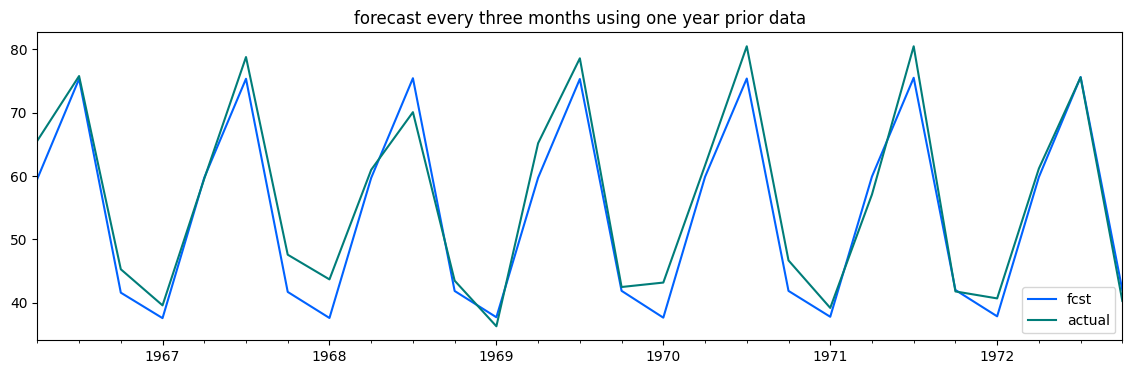

In [47]:
cv1.plot(title = 'forecast every three months using one year prior data')

In [48]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [49]:
mape(cv1)

0.052147971572693526

In [50]:
warnings.filterwarnings("ignore")
series = monthly_temp.temp
horizon = 12
start = 700
step_size = 3
order = (1,1,0)
seasonal_order = (0,1,1,12)

cv2 = cross_validate(monthly_temp.temp,12,700,3,
                    order = order,
                    seasonal_order = seasonal_order)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95524D+00    |proj g|=  7.03614D-02

At iterate    5    f=  2.85362D+00    |proj g|=  1.53755D-02

At iterate   10    f=  2.84755D+00    |proj g|=  2.41549D-04

At iterate   15    f=  2.84750D+00    |proj g|=  1.32048D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   6.414D-07   2.847D+00
  F =   2.8474972943545609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95337D+00    |proj g|=  7.05141D-02

At iterate    5    f=  2.85184D+00    |proj g|=  1.48083D-02

At iterate   10    f=  2.84568D+00    |proj g|=  2.56160D-04

At iterate   15    f=  2.84562D+00    |proj g|=  1.34456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   1.006D-06   2.846D+00
  F =   2.8456193278675674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  2.85352D+00    |proj g|=  1.32881D-02

At iterate   10    f=  2.84705D+00    |proj g|=  2.41771D-03

At iterate   15    f=  2.84693D+00    |proj g|=  5.70826D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     21      1     0     0   9.590D-06   2.847D+00
  F =   2.8469330521471630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95285D+00    |proj g|=  7.07072D-02

At iterate    5    f=  2.85277D+00    |proj g|=  1.28559D-02

At iterate   10    f=  2.84615D+00    |proj g|=  1.48873D-03

At iterate   15    f=  2.84603D+00    |proj g|=  2.84332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   4.179D-08   2.846D+00
  F =   2.8460326993907397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  2.85239D+00    |proj g|=  1.31303D-02

At iterate   10    f=  2.84549D+00    |proj g|=  1.98332D-03

At iterate   15    f=  2.84534D+00    |proj g|=  1.86788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   2.230D-06   2.845D+00
  F =   2.8453419688458919     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95137D+00    |proj g|=  7.09187D-02


 This problem is unconstrained.



At iterate    5    f=  2.85138D+00    |proj g|=  1.32128D-02

At iterate   10    f=  2.84441D+00    |proj g|=  2.08674D-03

At iterate   15    f=  2.84426D+00    |proj g|=  1.17336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   2.082D-06   2.844D+00
  F =   2.8442588695756079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95152D+00    |proj g|=  7.07070D-02


 This problem is unconstrained.



At iterate    5    f=  2.85053D+00    |proj g|=  1.48559D-02

At iterate   10    f=  2.84318D+00    |proj g|=  4.18498D-04

At iterate   15    f=  2.84301D+00    |proj g|=  1.60108D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   8.709D-07   2.843D+00
  F =   2.8430087288620030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94997D+00    |proj g|=  7.08449D-02


 This problem is unconstrained.



At iterate    5    f=  2.84806D+00    |proj g|=  1.47985D-02

At iterate   10    f=  2.84120D+00    |proj g|=  3.05478D-04

At iterate   15    f=  2.84108D+00    |proj g|=  7.10963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   4.940D-06   2.841D+00
  F =   2.8410765312295965     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95258D+00    |proj g|=  7.03747D-02


 This problem is unconstrained.



At iterate    5    f=  2.84669D+00    |proj g|=  1.17758D-02

At iterate   10    f=  2.84470D+00    |proj g|=  4.20127D-04

At iterate   15    f=  2.84465D+00    |proj g|=  6.75723D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   1.022D-06   2.845D+00
  F =   2.8446461861798040     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95205D+00    |proj g|=  7.04681D-02


 This problem is unconstrained.



At iterate    5    f=  2.84809D+00    |proj g|=  7.45626D-03

At iterate   10    f=  2.84404D+00    |proj g|=  3.17380D-04

At iterate   15    f=  2.84395D+00    |proj g|=  7.68297D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   8.783D-06   2.844D+00
  F =   2.8439515876783452     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95124D+00    |proj g|=  7.02340D-02


 This problem is unconstrained.



At iterate    5    f=  2.84683D+00    |proj g|=  7.07800D-03

At iterate   10    f=  2.84273D+00    |proj g|=  3.06925D-04

At iterate   15    f=  2.84261D+00    |proj g|=  5.92270D-04

At iterate   20    f=  2.84260D+00    |proj g|=  4.40935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   2.724D-06   2.843D+00
  F =   2.8426005456254755     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85395D+00    |proj g|=  1.89941D-02

At iterate   10    f=  2.84854D+00    |proj g|=  2.69183D-04

At iterate   15    f=  2.84841D+00    |proj g|=  1.44239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   7.140D-06   2.848D+00
  F =   2.8484041615512838     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95415D+00    |proj g|=  6.93313D-02


 This problem is unconstrained.



At iterate    5    f=  2.85182D+00    |proj g|=  6.83588D-03

At iterate   10    f=  2.84798D+00    |proj g|=  2.04119D-04

At iterate   15    f=  2.84789D+00    |proj g|=  3.27485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   7.160D-06   2.848D+00
  F =   2.8478927075956944     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95502D+00    |proj g|=  6.94215D-02


 This problem is unconstrained.



At iterate    5    f=  2.85247D+00    |proj g|=  6.83846D-03

At iterate   10    f=  2.84858D+00    |proj g|=  2.25958D-04

At iterate   15    f=  2.84848D+00    |proj g|=  4.32520D-04

At iterate   20    f=  2.84848D+00    |proj g|=  1.57998D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     23      1     0     0   1.580D-06   2.848D+00
  F =   2.8484826626539568     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85211D+00    |proj g|=  1.64905D-02

At iterate   10    f=  2.84737D+00    |proj g|=  2.41453D-04

At iterate   15    f=  2.84727D+00    |proj g|=  1.10399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   4.916D-06   2.847D+00
  F =   2.8472688167288038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95551D+00    |proj g|=  6.96269D-02


 This problem is unconstrained.



At iterate    5    f=  2.85430D+00    |proj g|=  1.60584D-02

At iterate   10    f=  2.84779D+00    |proj g|=  1.24386D-03

At iterate   15    f=  2.84765D+00    |proj g|=  2.99233D-04

At iterate   20    f=  2.84764D+00    |proj g|=  6.29807D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     25      1     0     0   6.298D-07   2.848D+00
  F =   2.8476411913843318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85439D+00    |proj g|=  1.64127D-02

At iterate   10    f=  2.84818D+00    |proj g|=  1.00173D-03

At iterate   15    f=  2.84810D+00    |proj g|=  1.81398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   8.668D-06   2.848D+00
  F =   2.8480968521600389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95701D+00    |proj g|=  7.00285D-02


 This problem is unconstrained.



At iterate    5    f=  2.85550D+00    |proj g|=  1.35205D-02

At iterate   10    f=  2.84902D+00    |proj g|=  1.34885D-03

At iterate   15    f=  2.84891D+00    |proj g|=  7.11004D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   1.536D-05   2.849D+00
  F =   2.8489147189852098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95898D+00    |proj g|=  6.94864D-02


 This problem is unconstrained.



At iterate    5    f=  2.85793D+00    |proj g|=  1.22953D-02

At iterate   10    f=  2.85075D+00    |proj g|=  1.10420D-03

At iterate   15    f=  2.85053D+00    |proj g|=  4.53141D-04

At iterate   20    f=  2.85052D+00    |proj g|=  2.28330D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   6.422D-06   2.851D+00
  F =   2.8505246002358668     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85739D+00    |proj g|=  1.98298D-02

At iterate   10    f=  2.85039D+00    |proj g|=  6.40139D-04

At iterate   15    f=  2.85018D+00    |proj g|=  6.91742D-04

At iterate   20    f=  2.85017D+00    |proj g|=  3.32283D-05

At iterate   25    f=  2.85017D+00    |proj g|=  3.29830D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   1.967D-05   2.850D+00
  F =   2.8501715824223384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.85853D+00    |proj g|=  1.68730D-02

At iterate   10    f=  2.85199D+00    |proj g|=  1.42984D-03

At iterate   15    f=  2.85188D+00    |proj g|=  2.00214D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   8.142D-06   2.852D+00
  F =   2.8518762403838318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95913D+00    |proj g|=  6.97263D-02


 This problem is unconstrained.



At iterate    5    f=  2.85772D+00    |proj g|=  1.59298D-02

At iterate   10    f=  2.85106D+00    |proj g|=  1.66458D-03

At iterate   15    f=  2.85093D+00    |proj g|=  3.28067D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   3.374D-05   2.851D+00
  F =   2.8509323071730179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95877D+00    |proj g|=  6.99065D-02


 This problem is unconstrained.



At iterate    5    f=  2.85809D+00    |proj g|=  1.70453D-02

At iterate   10    f=  2.85116D+00    |proj g|=  2.36932D-03

At iterate   15    f=  2.85094D+00    |proj g|=  1.09880D-03

At iterate   20    f=  2.85094D+00    |proj g|=  4.13520D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   4.529D-06   2.851D+00
  F =   2.8509364987286032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85659D+00    |proj g|=  1.61564D-02

At iterate   10    f=  2.84958D+00    |proj g|=  2.77406D-03

At iterate   15    f=  2.84935D+00    |proj g|=  1.01590D-03

At iterate   20    f=  2.84934D+00    |proj g|=  3.46577D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   2.985D-06   2.849D+00
  F =   2.8493382327256973     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85517D+00    |proj g|=  1.60497D-02

At iterate   10    f=  2.84813D+00    |proj g|=  1.94834D-03

At iterate   15    f=  2.84794D+00    |proj g|=  2.05584D-04

At iterate   20    f=  2.84794D+00    |proj g|=  9.55902D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   9.559D-06   2.848D+00
  F =   2.8479359927663990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85448D+00    |proj g|=  1.60478D-02

At iterate   10    f=  2.84748D+00    |proj g|=  1.83460D-03

At iterate   15    f=  2.84728D+00    |proj g|=  3.92748D-04

At iterate   20    f=  2.84727D+00    |proj g|=  2.09091D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   4.101D-06   2.847D+00
  F =   2.8472746451188726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85442D+00    |proj g|=  1.79755D-02

At iterate   10    f=  2.84734D+00    |proj g|=  1.76118D-03

At iterate   15    f=  2.84709D+00    |proj g|=  5.61820D-04

At iterate   20    f=  2.84706D+00    |proj g|=  7.66579D-04

At iterate   25    f=  2.84706D+00    |proj g|=  4.42270D-05

At iterate   30    f=  2.84706D+00    |proj g|=  5.55800D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     36      1     0     0   5.558D-06   2.847D+00
  F =   2.8470587786016988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [51]:
mape(cv2)

0.0683581529488676

<Axes: title={'center': 'forecast every three months using one year prior data'}>

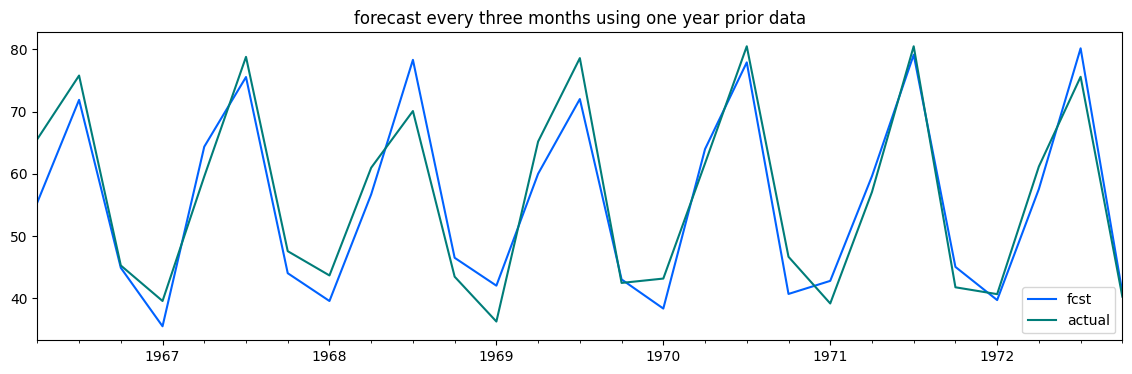

In [52]:
cv2.plot(title = 'forecast every three months using one year prior data')

In [53]:
mape(cv2)

0.0683581529488676

In [54]:
len(monthly_temp.temp)

792

In [55]:
def grid_search_ARIMA(series,horizon,start,step_size,orders = [(1,0,0)],seasonal_orders = [(0,0,0,0)],trends=[None]):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                
                cv = cross_validate(series,
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mape(cv)<best_mape:
                    best_mape = mape(cv)
                    best_order = order_
                    best_seasonal_order = seasonal_order_
                    best_trend = trend_
    return (best_order,best_seasonal_order, best_trend, best_mape)
    

In [56]:
series = monthly_temp.temp
horizon = 12
start = 760
step_size = 3
orders = [(1,1,0),(1,0,0)]
seasonal_orders = [(0,1,1,12)]
trends = [None,'c']

grid_search_ARIMA(series = series,
                  horizon = horizon,
                  start = start,
                  step_size = step_size,
                  orders = orders,
                  seasonal_orders = seasonal_orders,
                  trends=trends)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95960D+00    |proj g|=  6.95592D-02


 This problem is unconstrained.



At iterate    5    f=  2.85853D+00    |proj g|=  1.68730D-02

At iterate   10    f=  2.85199D+00    |proj g|=  1.42984D-03

At iterate   15    f=  2.85188D+00    |proj g|=  2.00214D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   8.142D-06   2.852D+00
  F =   2.8518762403838318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95913D+00    |proj g|=  6.97263D-02


 This problem is unconstrained.



At iterate    5    f=  2.85772D+00    |proj g|=  1.59298D-02

At iterate   10    f=  2.85106D+00    |proj g|=  1.66458D-03

At iterate   15    f=  2.85093D+00    |proj g|=  3.28067D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   3.374D-05   2.851D+00
  F =   2.8509323071730179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95877D+00    |proj g|=  6.99065D-02


 This problem is unconstrained.



At iterate    5    f=  2.85809D+00    |proj g|=  1.70453D-02

At iterate   10    f=  2.85116D+00    |proj g|=  2.36932D-03

At iterate   15    f=  2.85094D+00    |proj g|=  1.09880D-03

At iterate   20    f=  2.85094D+00    |proj g|=  4.13520D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   4.529D-06   2.851D+00
  F =   2.8509364987286032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85659D+00    |proj g|=  1.61564D-02

At iterate   10    f=  2.84958D+00    |proj g|=  2.77406D-03

At iterate   15    f=  2.84935D+00    |proj g|=  1.01590D-03

At iterate   20    f=  2.84934D+00    |proj g|=  3.46577D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   2.985D-06   2.849D+00
  F =   2.8493382327256973     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85517D+00    |proj g|=  1.60497D-02

At iterate   10    f=  2.84813D+00    |proj g|=  1.94834D-03

At iterate   15    f=  2.84794D+00    |proj g|=  2.05584D-04

At iterate   20    f=  2.84794D+00    |proj g|=  9.55902D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   9.559D-06   2.848D+00
  F =   2.8479359927663990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85448D+00    |proj g|=  1.60478D-02

At iterate   10    f=  2.84748D+00    |proj g|=  1.83460D-03

At iterate   15    f=  2.84728D+00    |proj g|=  3.92748D-04

At iterate   20    f=  2.84727D+00    |proj g|=  2.09091D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   4.101D-06   2.847D+00
  F =   2.8472746451188726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85442D+00    |proj g|=  1.79755D-02

At iterate   10    f=  2.84734D+00    |proj g|=  1.76118D-03

At iterate   15    f=  2.84709D+00    |proj g|=  5.61820D-04

At iterate   20    f=  2.84706D+00    |proj g|=  7.66579D-04

At iterate   25    f=  2.84706D+00    |proj g|=  4.42270D-05

At iterate   30    f=  2.84706D+00    |proj g|=  5.55800D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     36      1     0     0   5.558D-06   2.847D+00
  F =   2.8470587786016988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.85833D+00    |proj g|=  1.43670D-02

At iterate   10    f=  2.85214D+00    |proj g|=  1.19508D-02

At iterate   15    f=  2.85187D+00    |proj g|=  1.35481D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   6.143D-06   2.852D+00
  F =   2.8518737067318494     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95916D+00    |proj g|=  6.97170D-02


 This problem is unconstrained.



At iterate    5    f=  2.85764D+00    |proj g|=  1.17747D-02

At iterate   10    f=  2.85120D+00    |proj g|=  4.61067D-03

At iterate   15    f=  2.85092D+00    |proj g|=  2.83328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   3.718D-04   2.851D+00
  F =   2.8509193235603041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95884D+00    |proj g|=  6.98835D-02


 This problem is unconstrained.



At iterate    5    f=  2.85807D+00    |proj g|=  1.53189D-02

At iterate   10    f=  2.85137D+00    |proj g|=  1.86415D-02

At iterate   15    f=  2.85094D+00    |proj g|=  1.08989D-03

At iterate   20    f=  2.85093D+00    |proj g|=  3.74970D-03

At iterate   25    f=  2.85093D+00    |proj g|=  2.44296D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   2.443D-05   2.851D+00
  F =   2.8509250532614829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  2.85657D+00    |proj g|=  1.42808D-02

At iterate   10    f=  2.85023D+00    |proj g|=  6.62994D-03

At iterate   15    f=  2.84936D+00    |proj g|=  3.80758D-04

At iterate   20    f=  2.84933D+00    |proj g|=  1.37481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   6.500D-05   2.849D+00
  F =   2.8493303509169898     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85507D+00    |proj g|=  1.19682D-02

At iterate   10    f=  2.84835D+00    |proj g|=  1.28157D-02

At iterate   15    f=  2.84794D+00    |proj g|=  3.82471D-04

At iterate   20    f=  2.84794D+00    |proj g|=  5.98318D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   7.298D-05   2.848D+00
  F =   2.8479356734534647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85440D+00    |proj g|=  1.18963D-02

At iterate   10    f=  2.84762D+00    |proj g|=  3.17615D-03

At iterate   15    f=  2.84727D+00    |proj g|=  1.09441D-03

At iterate   20    f=  2.84726D+00    |proj g|=  1.89197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   8.672D-05   2.847D+00
  F =   2.8472577593669777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.85439D+00    |proj g|=  1.52330D-02

At iterate   10    f=  2.84769D+00    |proj g|=  2.05246D-02

At iterate   15    f=  2.84709D+00    |proj g|=  3.01764D-04

At iterate   20    f=  2.84706D+00    |proj g|=  5.89261D-04

At iterate   25    f=  2.84706D+00    |proj g|=  1.18875D-03

At iterate   30    f=  2.84706D+00    |proj g|=  2.12249D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     46      1     0     0   7.411D-05   2.847D+00
  F =   2.8470572913337455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80498D+00    |proj g|=  8.47324D-02


 This problem is unconstrained.



At iterate    5    f=  2.70878D+00    |proj g|=  1.86079D-02

At iterate   10    f=  2.69882D+00    |proj g|=  1.18983D-03

At iterate   15    f=  2.69862D+00    |proj g|=  1.62046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   1.604D-05   2.699D+00
  F =   2.6986192071674231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80439D+00    |proj g|=  8.47192D-02


 This problem is unconstrained.



At iterate    5    f=  2.70831D+00    |proj g|=  1.87578D-02

At iterate   10    f=  2.69824D+00    |proj g|=  1.13506D-03

At iterate   15    f=  2.69802D+00    |proj g|=  4.27452D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   8.608D-06   2.698D+00
  F =   2.6980155029775723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80375D+00    |proj g|=  8.50159D-02


 This problem is unconstrained.



At iterate    5    f=  2.70782D+00    |proj g|=  1.86705D-02

At iterate   10    f=  2.69775D+00    |proj g|=  1.06984D-03

At iterate   15    f=  2.69750D+00    |proj g|=  5.42658D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   5.979D-06   2.698D+00
  F =   2.6975035122100413     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80249D+00    |proj g|=  8.52656D-02


 This problem is unconstrained.



At iterate    5    f=  2.70638D+00    |proj g|=  1.86387D-02

At iterate   10    f=  2.69644D+00    |proj g|=  1.13487D-03

At iterate   15    f=  2.69621D+00    |proj g|=  1.17292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   1.385D-05   2.696D+00
  F =   2.6962127876627537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80167D+00    |proj g|=  8.53951D-02


 This problem is unconstrained.



At iterate    5    f=  2.70503D+00    |proj g|=  1.87050D-02

At iterate   10    f=  2.69498D+00    |proj g|=  1.03643D-03

At iterate   15    f=  2.69473D+00    |proj g|=  1.15044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   1.552D-05   2.695D+00
  F =   2.6947251768579195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80101D+00    |proj g|=  8.51957D-02


 This problem is unconstrained.



At iterate    5    f=  2.70472D+00    |proj g|=  1.84608D-02

At iterate   10    f=  2.69469D+00    |proj g|=  1.14851D-03

At iterate   15    f=  2.69453D+00    |proj g|=  1.49438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   8.642D-06   2.695D+00
  F =   2.6945295513497101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79983D+00    |proj g|=  8.53196D-02


 This problem is unconstrained.



At iterate    5    f=  2.70362D+00    |proj g|=  1.86393D-02

At iterate   10    f=  2.69341D+00    |proj g|=  7.32950D-04

At iterate   15    f=  2.69313D+00    |proj g|=  1.23264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   2.438D-06   2.693D+00
  F =   2.6931261401039261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80496D+00    |proj g|=  8.47325D-02


 This problem is unconstrained.



At iterate    5    f=  2.70950D+00    |proj g|=  2.07689D-02

At iterate   10    f=  2.69765D+00    |proj g|=  6.78525D-03

At iterate   15    f=  2.69692D+00    |proj g|=  9.78048D-03

At iterate   20    f=  2.69688D+00    |proj g|=  5.54019D-03

At iterate   25    f=  2.69688D+00    |proj g|=  1.73127D-04

At iterate   30    f=  2.69688D+00    |proj g|=  3.90322D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     37      1     0     0   3.839D-04   2.697D+00
  F =   2.6968762099692980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.70900D+00    |proj g|=  2.06165D-02

At iterate   10    f=  2.69698D+00    |proj g|=  1.56543D-02

At iterate   15    f=  2.69612D+00    |proj g|=  2.24991D-03

At iterate   20    f=  2.69606D+00    |proj g|=  3.63079D-03

At iterate   25    f=  2.69605D+00    |proj g|=  1.18930D-04

At iterate   30    f=  2.69605D+00    |proj g|=  6.07809D-04

At iterate   35    f=  2.69605D+00    |proj g|=  1.33842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     45      1     0     0   1.338D-04   2.696D+00
  F =   2.6960512277673758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.70964D+00    |proj g|=  2.50276D-02

At iterate   10    f=  2.69670D+00    |proj g|=  4.57906D-02

At iterate   15    f=  2.69553D+00    |proj g|=  5.56519D-03

At iterate   20    f=  2.69544D+00    |proj g|=  4.67769D-04

At iterate   25    f=  2.69543D+00    |proj g|=  4.28876D-04

At iterate   30    f=  2.69543D+00    |proj g|=  2.50524D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     36      1     0     0   1.886D-05   2.695D+00
  F =   2.6954298043107041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.70735D+00    |proj g|=  2.11557D-02

At iterate   10    f=  2.69505D+00    |proj g|=  3.00291D-02

At iterate   15    f=  2.69412D+00    |proj g|=  1.76420D-03

At iterate   20    f=  2.69406D+00    |proj g|=  2.76761D-03

At iterate   25    f=  2.69405D+00    |proj g|=  4.55343D-04

At iterate   30    f=  2.69405D+00    |proj g|=  2.27260D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     34      1     0     0   1.770D-05   2.694D+00
  F =   2.6940491568890828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.70629D+00    |proj g|=  2.18109D-02

At iterate   10    f=  2.69386D+00    |proj g|=  6.41016D-02

At iterate   15    f=  2.69284D+00    |proj g|=  3.88209D-04

At iterate   20    f=  2.69273D+00    |proj g|=  1.10197D-03

At iterate   25    f=  2.69271D+00    |proj g|=  1.34372D-04

At iterate   30    f=  2.69271D+00    |proj g|=  7.30987D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     45      1     0     0   2.865D-05   2.693D+00
  F =   2.6927113659215998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.70328D+00    |proj g|=  3.40650D-02

At iterate   10    f=  2.69304D+00    |proj g|=  1.99036D-02

At iterate   15    f=  2.69223D+00    |proj g|=  3.62972D-03

At iterate   20    f=  2.69218D+00    |proj g|=  4.66192D-03

At iterate   25    f=  2.69217D+00    |proj g|=  6.62142D-04

At iterate   30    f=  2.69217D+00    |proj g|=  3.17118D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   2.932D-05   2.692D+00
  F =   2.6921693005040011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  2.70369D+00    |proj g|=  2.35426D-02

At iterate   10    f=  2.69166D+00    |proj g|=  1.23352D-02

At iterate   15    f=  2.69094D+00    |proj g|=  7.64102D-04

At iterate   20    f=  2.69088D+00    |proj g|=  4.39629D-03

At iterate   25    f=  2.69087D+00    |proj g|=  4.66878D-04

At iterate   30    f=  2.69087D+00    |proj g|=  2.19572D-04

At iterate   35    f=  2.69087D+00    |proj g|=  4.97590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     44      1     0     0   4.976D-04   2.691D+00
  F =   2.6908736540430818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

((1, 0, 0), (0, 1, 1, 12), None, 0.035131645301189944)

### Forecasting Exercise:
1. Find appropriate model to forecast sunspots data
2. Run diagnostics to check if fit makes sense
3. Run cross-validation on a few different choices to see which one has best out of sample error

**Note:** This data is annual, but we still need to find the seasonality
The variance does not seem to stay constant throughout, think of transformations we discussed earlier in course to take care of this

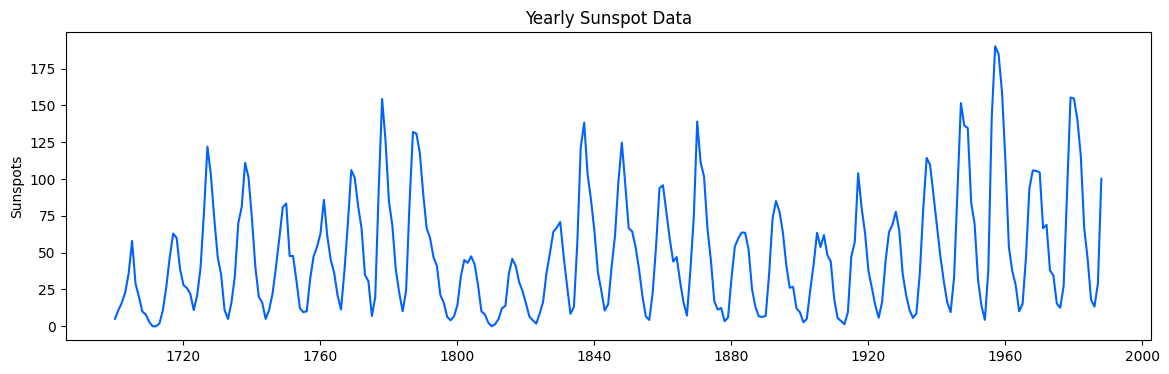

In [57]:
# read and plot data
data_path = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv'
data = pd.read_csv(data_path,usecols = ['time','value'],index_col = 'time',parse_dates=['time'])
plt.figure()
plt.plot(data.index,data['value'])
plt.ylabel('Sunspots')
plt.title('Yearly Sunspot Data');

In [59]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 289 entries, 1700-01-01 to 1988-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   289 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


value
time             
1700-01-01    5.0
1701-01-01   11.0
1702-01-01   16.0
1703-01-01   23.0
1704-01-01   36.0

([<matplotlib.axis.XTick at 0x7cb2054d8490>,
 [Text(-98615.0, 0, '1700-01-01'),
  Text(-94598.0, 0, '1711-01-01'),
  Text(-90580.0, 0, '1722-01-01'),
  Text(-86562.0, 0, '1733-01-01'),
  Text(-82545.0, 0, '1744-01-01'),
  Text(-78527.0, 0, '1755-01-01')])

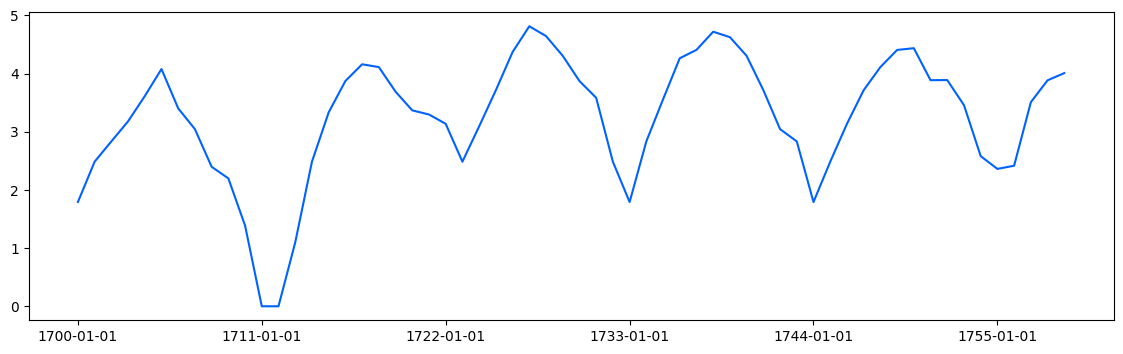

In [60]:
#given the difference in variance we should probably take log of data
data['log_ss'] = np.log1p(data['value'])
# going to zoom in on last 60 values to get a better idea of frequency of seasonality
plt.plot(data['log_ss'][:60])
plt.xticks(ticks = data.iloc[0:60:11].index)

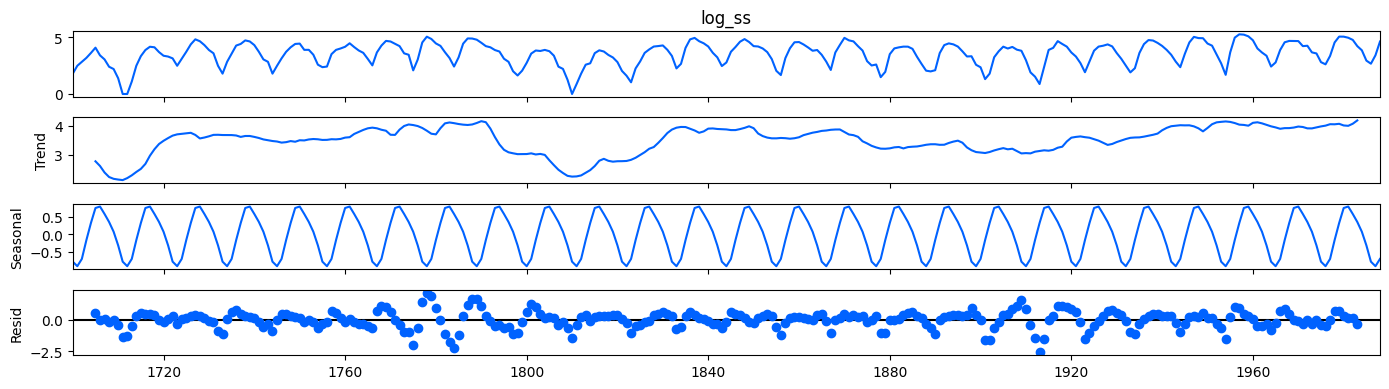

In [63]:
# plot decomposition with frequency 11
# Seems to do decent job of capturing seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(data.log_ss,period=11).plot();

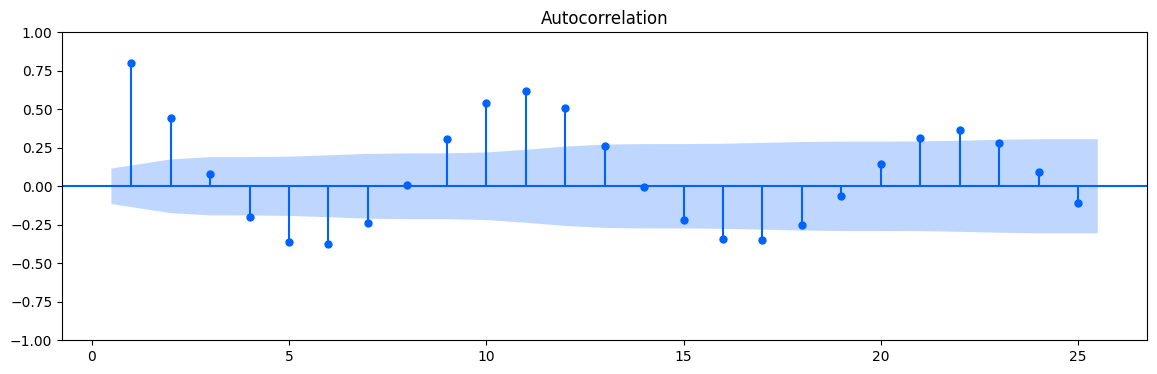

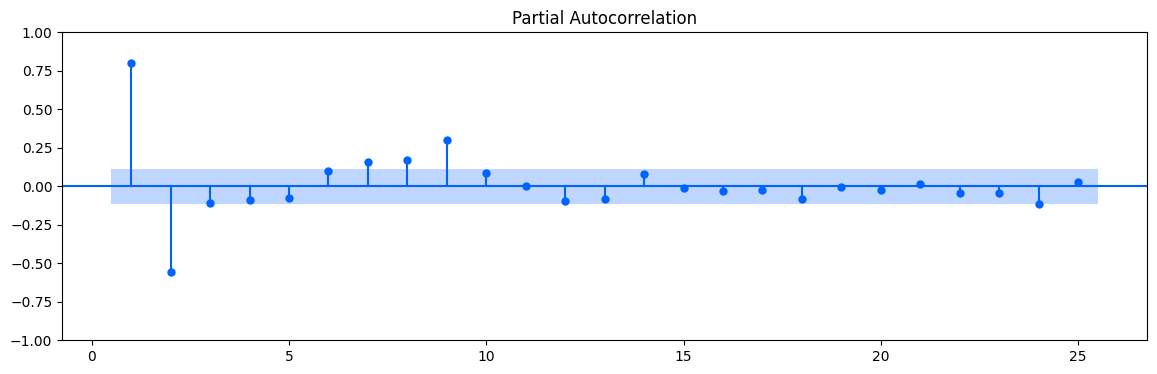

In [64]:
sm.tsa.graphics.plot_acf(data.log_ss,zero=False)
sm.tsa.graphics.plot_pacf(data.log_ss,zero = False);

In [65]:
data['lag_11'] = data.log_ss.shift(11)
data['seasonal_diff'] = data.log_ss - data['lag_11']

Test Statistic           -4.127070
p-value                   0.000873
Lags Used                12.000000
Observations Used       265.000000
Critical Value (1%)      -3.455270
Critical Value (5%)      -2.872509
Critical Value (10%)     -2.572615
dtype: float64


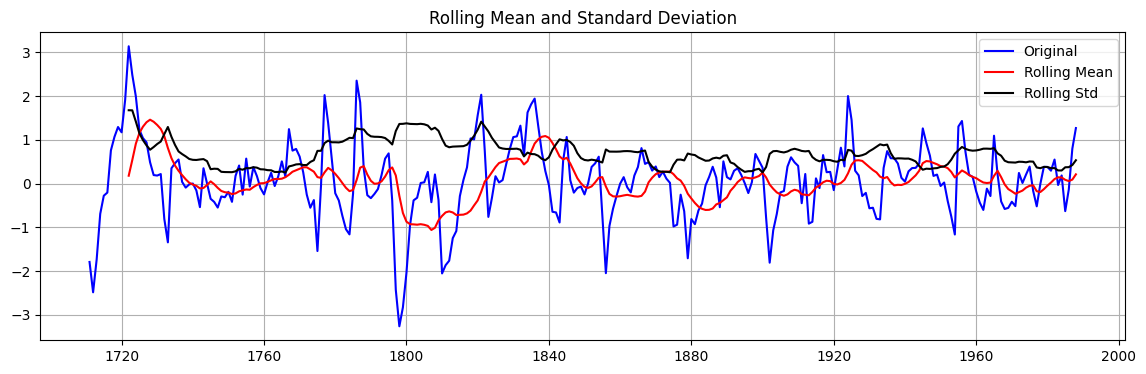

In [66]:
# mean moves, not perfect. p-value shows we can reject the null of non stationarity
dftest(data['seasonal_diff'].dropna())

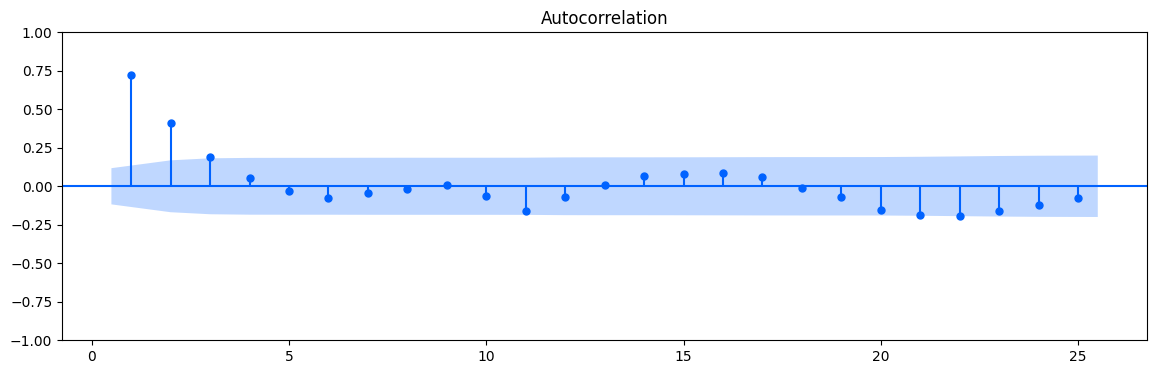

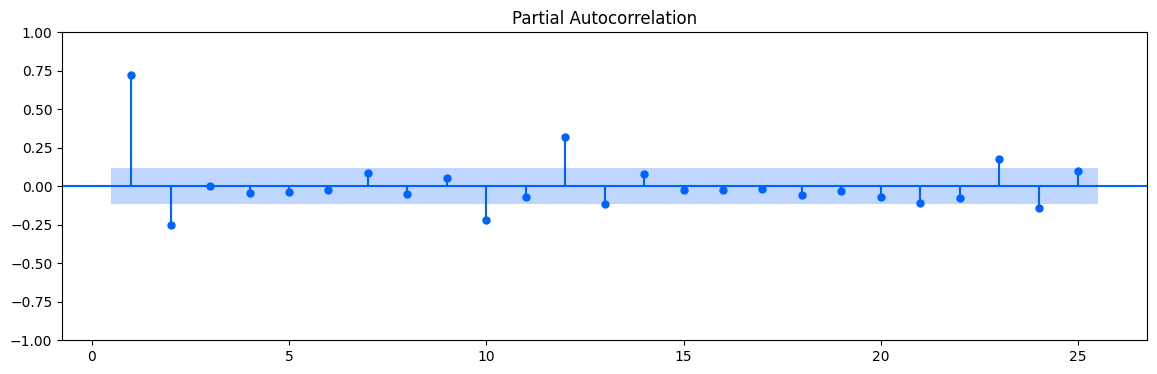

In [67]:
sm.tsa.graphics.plot_acf(data['seasonal_diff'].dropna(),zero=False)
sm.tsa.graphics.plot_pacf(data['seasonal_diff'].dropna(),zero=False);

In [68]:
data.head()

value    log_ss  lag_11  seasonal_diff
time                                              
1700-01-01    5.0  1.791759     NaN            NaN
1701-01-01   11.0  2.484907     NaN            NaN
1702-01-01   16.0  2.833213     NaN            NaN
1703-01-01   23.0  3.178054     NaN            NaN
1704-01-01   36.0  3.610918     NaN            NaN

looks like an ar2 model with seasonal differencing

In [69]:
sar3 = sm.tsa.statespace.SARIMAX(data.log_ss, 
                                order=(0,0,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33071D+00    |proj g|=  1.01987D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   1.019D-05   1.331D+00
  F =   1.3307099952842452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


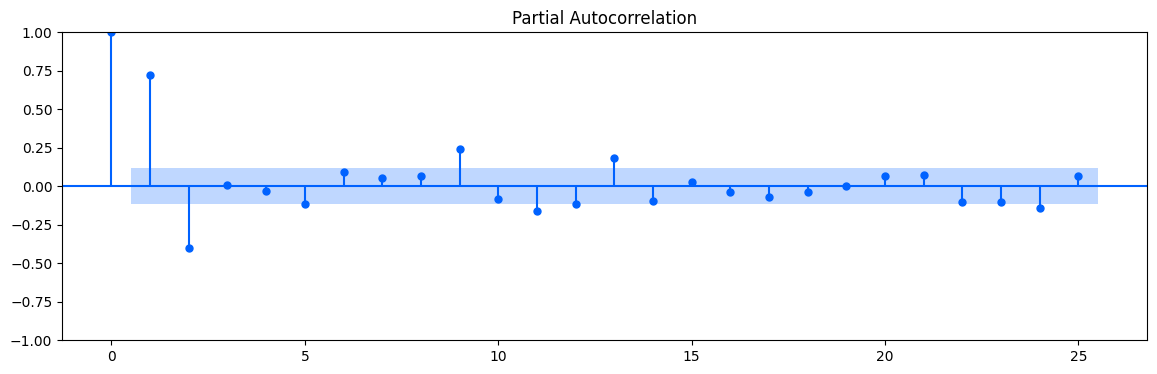

In [70]:
sm.tsa.graphics.plot_pacf(sar3.resid[sar3.loglikelihood_burn:]);

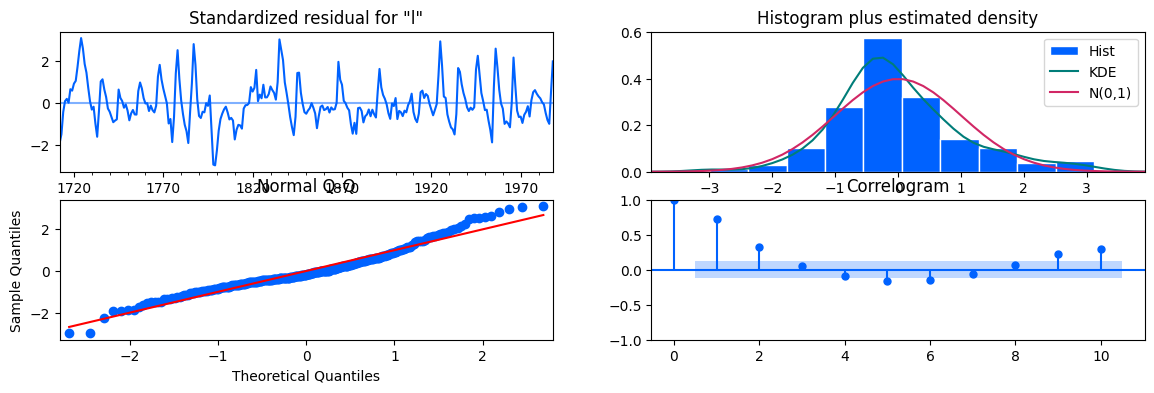

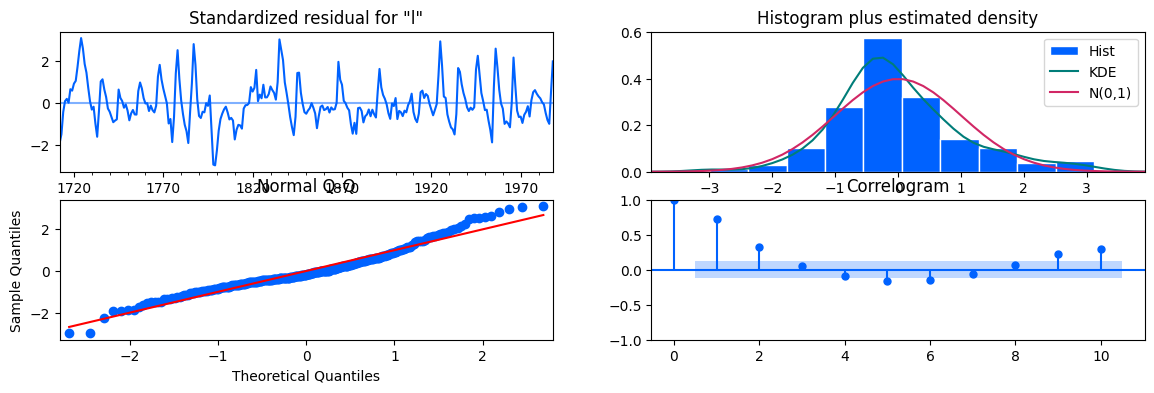

In [72]:
sar3.plot_diagnostics()

In [71]:
sar3.plot_diagnostics(figsize = (15,8),lags = range(1,15));

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1500x800 with 0 Axes>

In [73]:
auto_model = pm.auto_arima(data.log_ss, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=11,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[11] intercept   : AIC=694.412, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=708.047, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=464.732, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=501.605, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=707.239, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[11] intercept   : AIC=495.304, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[11] intercept   : AIC=450.988, Time=0.85 sec
 ARIMA(1,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(1,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(0,0,0)(2,1,0)[11] intercept   : AIC=688.783, Time=1.07 sec
 ARIMA(2,0,0)(2,1,0)[11] intercept   : AIC=425.830, Time=1.59 sec
 ARIMA(2,0,0)(1,1,0)[11] intercept   : AIC=443.928, Time=0.47 sec
 ARIMA(2,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(2,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(3,0,0)(2,1,0)[11] intercept   : AIC=427.82

In [74]:
print('order: ',auto_model.order)
print('seasonal order: ',auto_model.seasonal_order)

order:  (2, 0, 0)
seasonal order:  (2, 1, 0, 11)


In [75]:
sar4 = sm.tsa.statespace.SARIMAX(data.log_ss, 
                                order=(2,0,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62099D-01    |proj g|=  1.87701D-02

At iterate    5    f=  8.61996D-01    |proj g|=  7.09454D-04

At iterate   10    f=  8.61996D-01    |proj g|=  1.82245D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.822D-06   8.620D-01
  F =  0.86199566587811971     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


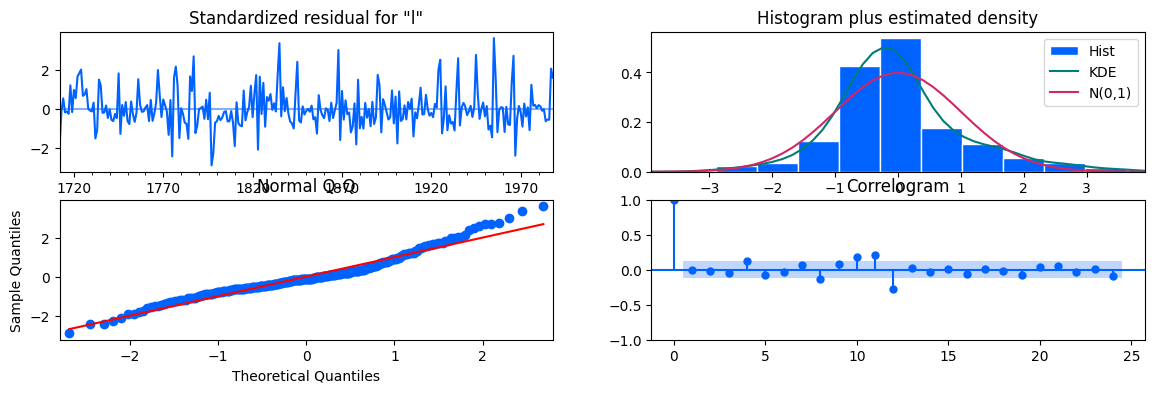

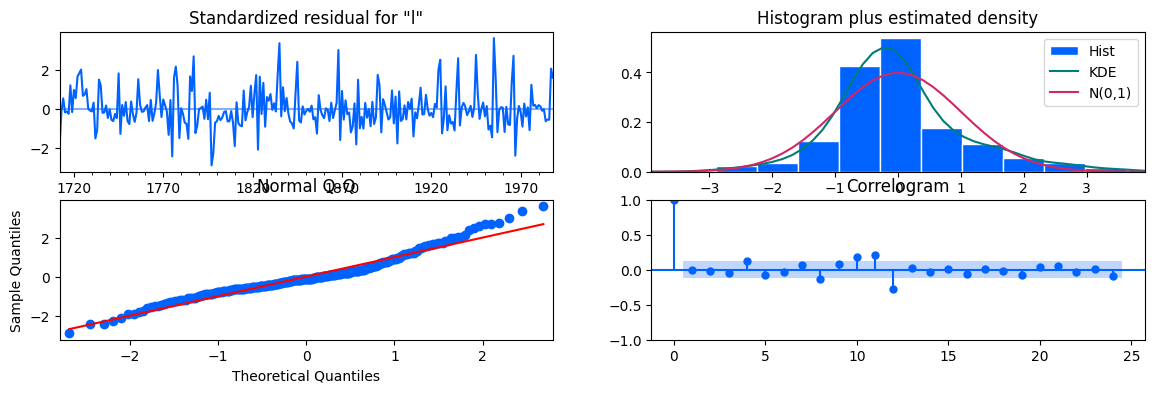

In [76]:
sar4.plot_diagnostics(lags=24)

In [77]:
warnings.filterwarnings("ignore")
series = data['log_ss']
horizon = 3
start = int(len(data.value)*.75)
step_size = 1
order = auto_model.order
seasonal_order = auto_model.seasonal_order

log_cv1 = cross_validate(series,horizon,start,step_size,
                    order = order,
                    seasonal_order = seasonal_order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84329D-01    |proj g|=  3.46756D-01

At iterate    5    f=  7.25733D-01    |proj g|=  1.39169D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.565D-06   7.255D-01
  F =  0.72550757744299010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86196D-01    |proj g|=  3.44723D-01


 This problem is unconstrained.



At iterate    5    f=  7.27608D-01    |proj g|=  1.29849D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.032D-06   7.274D-01
  F =  0.72740810669471068     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85343D-01    |proj g|=  3.47290D-01

At iterate    5    f=  7.26059D-01    |proj g|=  1.49646D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.398D-06   7.258D-01
  F =  0.72579856004084720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84175D-01    |proj g|=  3.47896D-01


 This problem is unconstrained.



At iterate    5    f=  7.24961D-01    |proj g|=  1.67843D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.365D-06   7.246D-01
  F =  0.72463035926242747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82444D-01    |proj g|=  3.47428D-01

At iterate    5    f=  7.23105D-01    |proj g|=  1.55758D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.660D-06   7.228D-01
  F =  0.72282464895790266     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82794D-01    |proj g|=  3.45590D-01


 This problem is unconstrained.



At iterate    5    f=  7.23628D-01    |proj g|=  1.66647D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.192D-06   7.233D-01
  F =  0.72330644816318057     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81113D-01    |proj g|=  3.46216D-01

At iterate    5    f=  7.21457D-01    |proj g|=  1.35650D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   7.203D-06   7.212D-01
  F =  0.72124073736497996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80596D-01    |proj g|=  3.51685D-01


 This problem is unconstrained.



At iterate    5    f=  7.20050D-01    |proj g|=  1.80473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.941D-06   7.197D-01
  F =  0.71967318396099489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92036D-01    |proj g|=  3.61732D-01


 This problem is unconstrained.



At iterate    5    f=  7.28889D-01    |proj g|=  5.68313D-02

At iterate   10    f=  7.24875D-01    |proj g|=  1.51179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   9.524D-06   7.249D-01
  F =  0.72487487886264945     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88896D-01    |proj g|=  3.55808D-01


 This problem is unconstrained.



At iterate    5    f=  7.27544D-01    |proj g|=  6.31697D-02

At iterate   10    f=  7.23339D-01    |proj g|=  1.70104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   2.582D-06   7.233D-01
  F =  0.72333933241288295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88788D-01    |proj g|=  3.58761D-01


 This problem is unconstrained.



At iterate    5    f=  7.26283D-01    |proj g|=  6.56626D-02

At iterate   10    f=  7.21836D-01    |proj g|=  1.78715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     21      1     0     0   1.729D-05   7.218D-01
  F =  0.72183569651786483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87238D-01    |proj g|=  3.60279D-01


 This problem is unconstrained.



At iterate    5    f=  7.24357D-01    |proj g|=  6.56935D-02

At iterate   10    f=  7.19865D-01    |proj g|=  1.46196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     27      1     0     0   1.206D-05   7.199D-01
  F =  0.71986493528058171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85648D-01    |proj g|=  3.62252D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.22342D-01    |proj g|=  6.64063D-02

At iterate   10    f=  7.17787D-01    |proj g|=  1.53082D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     20      1     0     0   1.285D-05   7.178D-01
  F =  0.71778725614058181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83802D-01    |proj g|=  3.63226D-01


 This problem is unconstrained.



At iterate    5    f=  7.20346D-01    |proj g|=  6.65946D-02

At iterate   10    f=  7.15742D-01    |proj g|=  1.53678D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     19      1     0     0   1.156D-05   7.157D-01
  F =  0.71574170575576168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82568D-01    |proj g|=  3.63464D-01


 This problem is unconstrained.



At iterate    5    f=  7.18967D-01    |proj g|=  6.72803D-02

At iterate   10    f=  7.14350D-01    |proj g|=  1.50399D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   9.100D-06   7.143D-01
  F =  0.71434949891907551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80795D-01    |proj g|=  3.64008D-01


 This problem is unconstrained.



At iterate    5    f=  7.17332D-01    |proj g|=  6.68505D-02

At iterate   10    f=  7.12703D-01    |proj g|=  1.46994D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   3.335D-06   7.127D-01
  F =  0.71270312266884828     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79192D-01    |proj g|=  3.65593D-01


 This problem is unconstrained.



At iterate    5    f=  7.15311D-01    |proj g|=  6.69434D-02

At iterate   10    f=  7.10702D-01    |proj g|=  1.28955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   2.518D-06   7.107D-01
  F =  0.71070167642444904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76589D-01    |proj g|=  3.62645D-01

At iterate    5    f=  7.13424D-01    |proj g|=  6.91679D-02


 This problem is unconstrained.



At iterate   10    f=  7.08817D-01    |proj g|=  1.21996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.595D-06   7.088D-01
  F =  0.70881740970475160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83045D-01    |proj g|=  3.62990D-01


 This problem is unconstrained.



At iterate    5    f=  7.19947D-01    |proj g|=  6.26595D-02

At iterate   10    f=  7.15480D-01    |proj g|=  1.21586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   4.469D-06   7.155D-01
  F =  0.71547976576371430     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84204D-01    |proj g|=  3.72404D-01

At iterate    5    f=  7.21888D-01    |proj g|=  5.98699D-02


 This problem is unconstrained.



At iterate   10    f=  7.17417D-01    |proj g|=  9.48472D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   4.830D-06   7.174D-01
  F =  0.71741724444742261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83780D-01    |proj g|=  3.79240D-01


 This problem is unconstrained.



At iterate    5    f=  7.16293D-01    |proj g|=  9.30807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   7.345D-06   7.162D-01
  F =  0.71619302949924324     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82899D-01    |proj g|=  3.83550D-01

At iterate    5    f=  7.14522D-01    |proj g|=  1.40377D-02


 This problem is unconstrained.



At iterate   10    f=  7.14290D-01    |proj g|=  6.66256D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   6.663D-07   7.143D-01
  F =  0.71429044964978305     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81097D-01    |proj g|=  3.84527D-01


 This problem is unconstrained.



At iterate    5    f=  7.12549D-01    |proj g|=  1.44031D-02

At iterate   10    f=  7.12309D-01    |proj g|=  8.73523D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   8.735D-07   7.123D-01
  F =  0.71230947416184009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78986D-01    |proj g|=  3.83433D-01

At iterate    5    f=  7.10626D-01    |proj g|=  1.20928D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   7.386D-06   7.105D-01
  F =  0.71045543375756182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77015D-01    |proj g|=  3.83429D-01


 This problem is unconstrained.



At iterate    5    f=  7.08628D-01    |proj g|=  1.15246D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   9.142D-06   7.085D-01
  F =  0.70847328287735178     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75260D-01    |proj g|=  3.83694D-01

At iterate    5    f=  7.06727D-01    |proj g|=  1.04618D-02


 This problem is unconstrained.



At iterate   10    f=  7.06600D-01    |proj g|=  1.21074D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     21      1     0     0   1.211D-05   7.066D-01
  F =  0.70660013297055446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73095D-01    |proj g|=  3.83004D-01


 This problem is unconstrained.



At iterate    5    f=  7.04722D-01    |proj g|=  8.34608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.402D-06   7.046D-01
  F =  0.70464762971749229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70876D-01    |proj g|=  3.82216D-01

At iterate    5    f=  7.07032D-01    |proj g|=  5.60390D-02


 This problem is unconstrained.



At iterate   10    f=  7.02698D-01    |proj g|=  5.72525D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   4.384D-06   7.027D-01
  F =  0.70269776282204988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68692D-01    |proj g|=  3.78755D-01


 This problem is unconstrained.



At iterate    5    f=  7.05621D-01    |proj g|=  5.69539D-02

At iterate   10    f=  7.01258D-01    |proj g|=  7.66917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   3.728D-06   7.013D-01
  F =  0.70125772461710700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74097D-01    |proj g|=  3.63347D-01

At iterate    5    f=  7.16341D-01    |proj g|=  5.55419D-02


 This problem is unconstrained.



At iterate   10    f=  7.12290D-01    |proj g|=  9.18780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   9.129D-06   7.123D-01
  F =  0.71228991760268257     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74624D-01    |proj g|=  3.61960D-01


 This problem is unconstrained.



At iterate    5    f=  7.15573D-01    |proj g|=  5.84981D-02

At iterate   10    f=  7.11326D-01    |proj g|=  1.77341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.330D-06   7.113D-01
  F =  0.71132645869596611     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73611D-01    |proj g|=  3.62540D-01

At iterate    5    f=  7.09780D-01    |proj g|=  1.20160D-02


 This problem is unconstrained.



At iterate   10    f=  7.09559D-01    |proj g|=  1.76642D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.766D-06   7.096D-01
  F =  0.70955893188771690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72610D-01    |proj g|=  3.64369D-01


 This problem is unconstrained.



At iterate    5    f=  7.08574D-01    |proj g|=  1.50956D-02

At iterate   10    f=  7.08276D-01    |proj g|=  1.17618D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.176D-05   7.083D-01
  F =  0.70827610584862610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71489D-01    |proj g|=  3.64745D-01

At iterate    5    f=  7.07612D-01    |proj g|=  1.67860D-02


 This problem is unconstrained.



At iterate   10    f=  7.07249D-01    |proj g|=  1.22292D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.223D-06   7.072D-01
  F =  0.70724924316605309     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70243D-01    |proj g|=  3.63633D-01


 This problem is unconstrained.



At iterate    5    f=  7.07033D-01    |proj g|=  1.65326D-02

At iterate   10    f=  7.06684D-01    |proj g|=  1.39537D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.395D-06   7.067D-01
  F =  0.70668444866835034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68538D-01    |proj g|=  3.63485D-01

At iterate    5    f=  7.05473D-01    |proj g|=  1.62396D-02


 This problem is unconstrained.



At iterate   10    f=  7.05133D-01    |proj g|=  8.29237D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   8.292D-07   7.051D-01
  F =  0.70513331021546199     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  7.68121D-01    |proj g|=  3.63023D-01

At iterate    5    f=  7.05072D-01    |proj g|=  1.71532D-02

At iterate   10    f=  7.04697D-01    |proj g|=  1.44740D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.447D-06   7.047D-01
  F =  0.70469747743050914     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66620D-01    |proj g|=  3.60310D-01


 This problem is unconstrained.



At iterate    5    f=  7.03784D-01    |proj g|=  1.42991D-02

At iterate   10    f=  7.03505D-01    |proj g|=  9.15467D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   9.155D-06   7.035D-01
  F =  0.70350492378205387     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66568D-01    |proj g|=  3.55031D-01

At iterate    5    f=  7.04446D-01    |proj g|=  1.16924D-02


 This problem is unconstrained.



At iterate   10    f=  7.04232D-01    |proj g|=  1.57663D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.577D-06   7.042D-01
  F =  0.70423238314227399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97331D-01    |proj g|=  3.26768D-01


 This problem is unconstrained.



At iterate    5    f=  7.43395D-01    |proj g|=  9.96430D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   8.711D-06   7.433D-01
  F =  0.74326639433351027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99222D-01    |proj g|=  3.35220D-01

At iterate    5    f=  7.43046D-01    |proj g|=  1.83304D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.707D-06   7.426D-01
  F =  0.74260957143441753     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99221D-01    |proj g|=  3.38058D-01


 This problem is unconstrained.



At iterate    5    f=  7.42498D-01    |proj g|=  1.69709D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.042D-06   7.421D-01
  F =  0.74212088458024306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97847D-01    |proj g|=  3.39283D-01

At iterate    5    f=  7.40694D-01    |proj g|=  1.69303D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.887D-06   7.403D-01
  F =  0.74032389010577360     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.96324D-01    |proj g|=  3.39627D-01


 This problem is unconstrained.



At iterate    5    f=  7.39008D-01    |proj g|=  1.70956D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.686D-06   7.386D-01
  F =  0.73862646138113663     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94858D-01    |proj g|=  3.40011D-01

At iterate    5    f=  7.37369D-01    |proj g|=  1.73888D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.908D-06   7.370D-01
  F =  0.73698148243559392     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93590D-01    |proj g|=  3.39482D-01


 This problem is unconstrained.



At iterate    5    f=  7.36389D-01    |proj g|=  1.71783D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.344D-06   7.360D-01
  F =  0.73600865754432632     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92083D-01    |proj g|=  3.39944D-01

At iterate    5    f=  7.34698D-01    |proj g|=  1.74145D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.843D-06   7.343D-01
  F =  0.73430987074634813     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91128D-01    |proj g|=  3.41615D-01


 This problem is unconstrained.



At iterate    5    f=  7.33279D-01    |proj g|=  1.72687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.566D-06   7.329D-01
  F =  0.73289865354556338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90466D-01    |proj g|=  3.40810D-01

At iterate    5    f=  7.33159D-01    |proj g|=  1.68136D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.393D-06   7.328D-01
  F =  0.73278405091840504     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97041D-01    |proj g|=  3.34608D-01


 This problem is unconstrained.



At iterate    5    f=  7.40369D-01    |proj g|=  1.83925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.163D-06   7.400D-01
  F =  0.73997241094587607     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98625D-01    |proj g|=  3.49078D-01

At iterate    5    f=  7.38686D-01    |proj g|=  1.85381D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   5.506D-06   7.383D-01
  F =  0.73828014516571272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97014D-01    |proj g|=  3.49062D-01


 This problem is unconstrained.



At iterate    5    f=  7.37103D-01    |proj g|=  1.91504D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   5.008D-06   7.367D-01
  F =  0.73669573398245081     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95181D-01    |proj g|=  3.47760D-01

At iterate    5    f=  7.36018D-01    |proj g|=  1.86874D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   4.541D-06   7.356D-01
  F =  0.73563288169058438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93405D-01    |proj g|=  3.47826D-01


 This problem is unconstrained.



At iterate    5    f=  7.34328D-01    |proj g|=  1.86446D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   5.062D-06   7.339D-01
  F =  0.73394310853082423     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91613D-01    |proj g|=  3.47885D-01

At iterate    5    f=  7.32564D-01    |proj g|=  1.87379D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   5.773D-06   7.322D-01
  F =  0.73217827729651308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90432D-01    |proj g|=  3.47597D-01


 This problem is unconstrained.



At iterate    5    f=  7.31571D-01    |proj g|=  1.87967D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   5.126D-06   7.312D-01
  F =  0.73118130244190216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90413D-01    |proj g|=  3.46786D-01


 This problem is unconstrained.



At iterate    5    f=  7.31476D-01    |proj g|=  1.91003D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   5.778D-06   7.311D-01
  F =  0.73109470403762233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89442D-01    |proj g|=  3.44961D-01


 This problem is unconstrained.



At iterate    5    f=  7.31160D-01    |proj g|=  1.89991D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   4.346D-06   7.308D-01
  F =  0.73078180423263839     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87945D-01    |proj g|=  3.43870D-01

At iterate    5    f=  7.30100D-01    |proj g|=  1.87729D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   4.748D-06   7.297D-01
  F =  0.72973540879325938     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86203D-01    |proj g|=  3.44241D-01


 This problem is unconstrained.



At iterate    5    f=  7.28393D-01    |proj g|=  1.85752D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   5.710D-06   7.280D-01
  F =  0.72803717575341831     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85218D-01    |proj g|=  3.48272D-01

At iterate    5    f=  7.26658D-01    |proj g|=  1.84749D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   7.356D-06   7.263D-01
  F =  0.72630966445143497     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83544D-01    |proj g|=  3.49996D-01


 This problem is unconstrained.



At iterate    5    f=  7.24954D-01    |proj g|=  1.74293D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.148D-05   7.246D-01
  F =  0.72462474690536349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82551D-01    |proj g|=  3.48938D-01

At iterate    5    f=  7.23700D-01    |proj g|=  1.75253D-02


 This problem is unconstrained.



At iterate   10    f=  7.23382D-01    |proj g|=  3.04614D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   3.046D-06   7.234D-01
  F =  0.72338240332853732     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80615D-01    |proj g|=  3.46760D-01

At iterate    5    f=  7.21978D-01    |proj g|=  1.54174D-02


 This problem is unconstrained.



At iterate   10    f=  7.21729D-01    |proj g|=  2.08460D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     19      1     0     0   2.085D-05   7.217D-01
  F =  0.72172903660087007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78605D-01    |proj g|=  3.45405D-01


 This problem is unconstrained.



At iterate    5    f=  7.20258D-01    |proj g|=  1.32060D-02

At iterate   10    f=  7.20066D-01    |proj g|=  1.26397D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.264D-06   7.201D-01
  F =  0.72006641166223351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76766D-01    |proj g|=  3.44700D-01

At iterate    5    f=  7.18545D-01    |proj g|=  1.17335D-02


 This problem is unconstrained.



At iterate   10    f=  7.18388D-01    |proj g|=  2.26877D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   2.269D-06   7.184D-01
  F =  0.71838755779141250     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75227D-01    |proj g|=  3.44083D-01


 This problem is unconstrained.



At iterate    5    f=  7.16975D-01    |proj g|=  8.54138D-03

At iterate   10    f=  7.16881D-01    |proj g|=  2.03544D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   2.035D-06   7.169D-01
  F =  0.71688089625880280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74739D-01    |proj g|=  3.46097D-01


 This problem is unconstrained.



At iterate    5    f=  7.15773D-01    |proj g|=  9.98682D-03

At iterate   10    f=  7.15654D-01    |proj g|=  1.44598D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.446D-06   7.157D-01
  F =  0.71565385331161091     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73512D-01    |proj g|=  3.46576D-01

At iterate    5    f=  7.14217D-01    |proj g|=  9.31282D-03


 This problem is unconstrained.



At iterate   10    f=  7.14110D-01    |proj g|=  1.27149D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.271D-06   7.141D-01
  F =  0.71410982304919457     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74729D-01    |proj g|=  3.44893D-01


 This problem is unconstrained.



At iterate    5    f=  7.18576D-01    |proj g|=  6.04412D-02

At iterate   10    f=  7.14914D-01    |proj g|=  7.93191D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     21      1     0     0   1.594D-05   7.149D-01
  F =  0.71491414552924326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [78]:
log_cv1 = np.expm1(log_cv1)

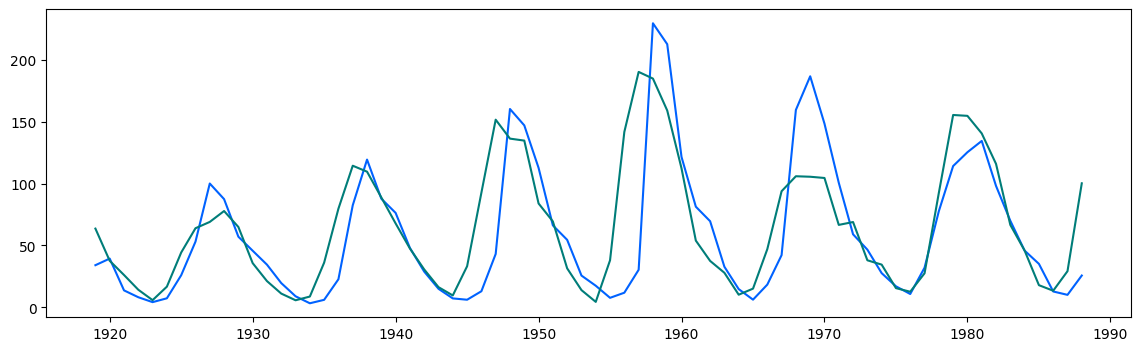

In [79]:
plt.plot(log_cv1)

In [80]:
mape(log_cv1)

0.3765505720125078

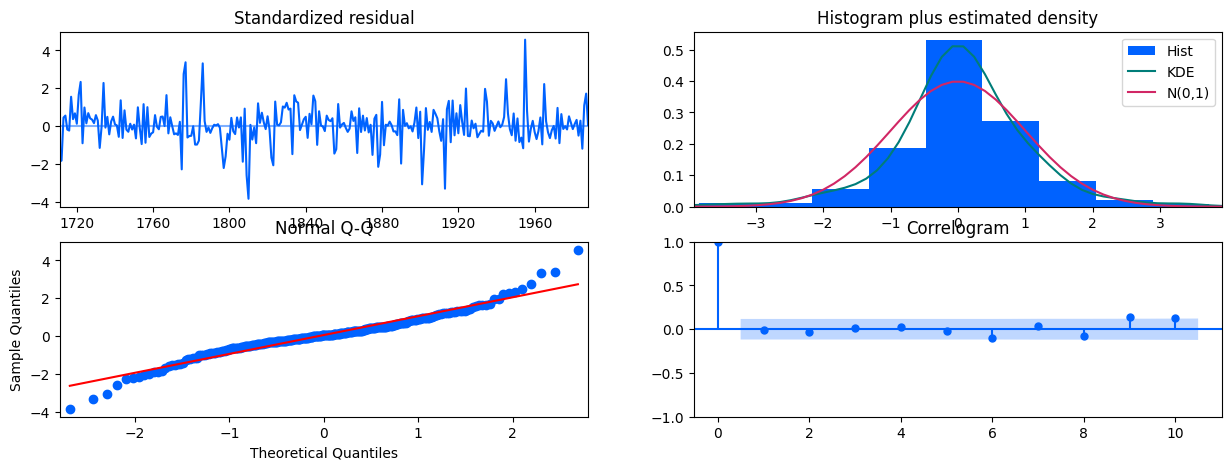

In [81]:
auto_model.plot_diagnostics(figsize = (15,5));

In [82]:
warnings.filterwarnings("ignore")
series = data['log_ss']
horizon = 3
start = int(len(data.value)*.75)
step_size = 1
order = (2,0,0)
seasonal_order = (1,1,0,11)

log_cv2 = cross_validate(series,horizon,start,step_size,
                    order = order,
                    seasonal_order = seasonal_order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84222D-01    |proj g|=  1.67488D-01

At iterate    5    f=  7.60551D-01    |proj g|=  8.60781D-03

At iterate   10    f=  7.60384D-01    |proj g|=  1.28322D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.283D-06   7.604D-01
  F =  0.76038405961310318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.62652D-01    |proj g|=  8.37461D-03

At iterate   10    f=  7.62489D-01    |proj g|=  2.10727D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   2.107D-06   7.625D-01
  F =  0.76248912479111353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85249D-01    |proj g|=  1.68846D-01


 This problem is unconstrained.



At iterate    5    f=  7.61021D-01    |proj g|=  8.48520D-03

At iterate   10    f=  7.60854D-01    |proj g|=  1.27091D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.271D-06   7.609D-01
  F =  0.76085420745348642     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83735D-01    |proj g|=  1.69520D-01


 This problem is unconstrained.



At iterate    5    f=  7.59404D-01    |proj g|=  8.79177D-03

At iterate   10    f=  7.59225D-01    |proj g|=  1.39280D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.393D-06   7.592D-01
  F =  0.75922502389233237     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82466D-01    |proj g|=  1.69085D-01

At iterate    5    f=  7.58280D-01    |proj g|=  8.62512D-03


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   9.658D-06   7.581D-01
  F =  0.75810756643057631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82906D-01    |proj g|=  1.68288D-01

At iterate    5    f=  7.58928D-01    |proj g|=  8.92539D-03

At iterate   10    f=  7.58744D-01    |proj g|=  1.93846D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79766D-01    |proj g|=  1.71270D-01

At iterate    5    f=  7.54980D-01    |proj g|=  8.75802D-03

At iterate   10    f=  7.54801D-01    |proj g|=  3.10236D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   3.102D-06   7.548D-01
  F =  0.75480123289928458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95452D-01    |proj g|=  1.79869D-01

At iterate    5    f=  7.66758D-01    |proj g|=  7.72427D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   6.412D-06   7.666D-01
  F =  0.76661669394162923     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93294D-01    |proj g|=  1.72624D-01

At iterate    5    f=  7.66170D-01    |proj g|=  1.73743D-02

At iterate   10    f=  7.65956D-01    |proj g|=  4.35886D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   4.359D-06   7.660D-01
  F =  0.76595622234417149     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92968D-01    |proj g|=  1.75013D-01

At iterate    5    f=  7.64894D-01    |proj g|=  1.23135D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     17      1     0     0   1.831D-05   7.646D-01
  F =  0.76464057116381334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91243D-01    |proj g|=  1.75846D-01

At iterate    5    f=  7.62815D-01    |proj g|=  7.89864D-03


 This problem is unconstrained.



At iterate   10    f=  7.62672D-01    |proj g|=  1.48720D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   1.487D-06   7.627D-01
  F =  0.76267200878562469     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89593D-01    |proj g|=  1.77244D-01

At iterate    5    f=  7.60887D-01    |proj g|=  1.95525D-02

At iterate   10    f=  7.60656D-01    |proj g|=  6.15398D-06

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87560D-01    |proj g|=  1.77151D-01

At iterate    5    f=  7.58849D-01    |proj g|=  1.92401D-02

At iterate   10    f=  7.58629D-01    |proj g|=  4.64450D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   4.644D-06   7.586D-01
  F =  0.75862877177884047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.57757D-01    |proj g|=  1.86668D-02

At iterate   10    f=  7.57540D-01    |proj g|=  5.15683D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   5.157D-06   7.575D-01
  F =  0.75754037538787167     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84742D-01    |proj g|=  1.77072D-01

At iterate    5    f=  7.55997D-01    |proj g|=  2.01880D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80690D-01    |proj g|=  1.75791D-01

At iterate    5    f=  7.52197D-01    |proj g|=  2.04004D-02

At iterate   10    f=  7.51967D-01    |proj g|=  2.32753D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   2.328D-06   7.520D-01
  F =  0.75196737258284929     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84498D-01    |proj g|=  1.76787D-01

At iterate    5    f=  7.55217D-01    |proj g|=  2.10747D-02

At iterate   10    f=  7.54993D-01    |proj g|=  3.90422D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   3.904D-06   7.550D-01
  F =  0.75499313929812373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.58903D-01    |proj g|=  7.41234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   5.726D-06   7.588D-01
  F =  0.75877779459223327     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85923D-01    |proj g|=  1.83248D-01


 This problem is unconstrained.



At iterate    5    f=  7.57492D-01    |proj g|=  8.30694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.498D-05   7.573D-01
  F =  0.75733540215836670     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84250D-01    |proj g|=  1.85234D-01


 This problem is unconstrained.



At iterate    5    f=  7.55525D-01    |proj g|=  8.43954D-03

At iterate   10    f=  7.55365D-01    |proj g|=  3.53707D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   3.537D-06   7.554D-01
  F =  0.75536488496443088     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82467D-01    |proj g|=  1.85446D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.53759D-01    |proj g|=  8.61562D-03

At iterate   10    f=  7.53592D-01    |proj g|=  5.50290D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   5.503D-06   7.536D-01
  F =  0.75359151263366408     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80831D-01    |proj g|=  1.84239D-01

At iterate    5    f=  7.52551D-01    |proj g|=  8.47678D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77166D-01    |proj g|=  1.84617D-01

At iterate    5    f=  7.48797D-01    |proj g|=  8.42676D-03

At iterate   10    f=  7.48639D-01    |proj g|=  6.22182D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   6.222D-06   7.486D-01
  F =  0.74863911784427417     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  7.46882D-01    |proj g|=  8.29345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   8.081D-06   7.467D-01
  F =  0.74672918821327061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73031D-01    |proj g|=  1.83286D-01


 This problem is unconstrained.



At iterate    5    f=  7.44989D-01    |proj g|=  8.14551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   3.338D-06   7.448D-01
  F =  0.74484268468613191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71056D-01    |proj g|=  1.82371D-01


 This problem is unconstrained.



At iterate    5    f=  7.43191D-01    |proj g|=  7.94446D-03

At iterate   10    f=  7.43053D-01    |proj g|=  1.33473D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.335D-06   7.431D-01
  F =  0.74305260033482590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  7.77324D-01    |proj g|=  1.71263D-01

At iterate    5    f=  7.52994D-01    |proj g|=  8.41348D-03

At iterate   10    f=  7.52831D-01    |proj g|=  7.52383D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.524D-06   7.528D-01
  F =  0.75283068738774905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76344D-01    |proj g|=  1.75458D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  7.51151D-01    |proj g|=  6.03840D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   6.038D-06   7.512D-01
  F =  0.75115065118666857     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74901D-01    |proj g|=  1.77891D-01

At iterate    5    f=  7.49446D-01    |proj g|=  9.12258D-03


 This problem is unconstrained.



At iterate   10    f=  7.49256D-01    |proj g|=  7.90392D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.904D-06   7.493D-01
  F =  0.74925621188818159     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73364D-01    |proj g|=  1.79027D-01


 This problem is unconstrained.



At iterate    5    f=  7.47671D-01    |proj g|=  9.19471D-03

At iterate   10    f=  7.47479D-01    |proj g|=  7.10074D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.101D-06   7.475D-01
  F =  0.74747926445867463     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71937D-01    |proj g|=  1.79469D-01

At iterate    5    f=  7.46172D-01    |proj g|=  9.38875D-03


 This problem is unconstrained.



At iterate   10    f=  7.45972D-01    |proj g|=  1.01363D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.014D-05   7.460D-01
  F =  0.74597150464300543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70432D-01    |proj g|=  1.78933D-01


 This problem is unconstrained.



At iterate    5    f=  7.44840D-01    |proj g|=  9.34115D-03

At iterate   10    f=  7.44643D-01    |proj g|=  7.99937D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.999D-06   7.446D-01
  F =  0.74464301806970645     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68704D-01    |proj g|=  1.78873D-01


 This problem is unconstrained.



At iterate    5    f=  7.43144D-01    |proj g|=  9.38824D-03

At iterate   10    f=  7.42945D-01    |proj g|=  1.07796D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.078D-05   7.429D-01
  F =  0.74294491581109623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67825D-01    |proj g|=  1.79199D-01


 This problem is unconstrained.



At iterate    5    f=  7.42101D-01    |proj g|=  9.36193D-03

At iterate   10    f=  7.41903D-01    |proj g|=  8.71178D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   8.712D-06   7.419D-01
  F =  0.74190346786170935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66511D-01    |proj g|=  1.78354D-01

At iterate    5    f=  7.40908D-01    |proj g|=  9.20408D-03


 This problem is unconstrained.



At iterate   10    f=  7.40718D-01    |proj g|=  7.83649D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.836D-06   7.407D-01
  F =  0.74071817652278182     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66117D-01    |proj g|=  1.76812D-01


 This problem is unconstrained.



At iterate    5    f=  7.40732D-01    |proj g|=  8.97091D-03

At iterate   10    f=  7.40552D-01    |proj g|=  8.96280D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   8.963D-06   7.406D-01
  F =  0.74055186102361859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98429D-01    |proj g|=  1.60036D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.76714D-01    |proj g|=  8.25595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   6.954D-06   7.766D-01
  F =  0.77656295671929876     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98554D-01    |proj g|=  1.69286D-01

At iterate    5    f=  7.74945D-01    |proj g|=  8.00313D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.74218D-01    |proj g|=  5.94729D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   7.598D-06   7.741D-01
  F =  0.77414534565025295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.96552D-01    |proj g|=  1.73359D-01

At iterate    5    f=  7.72423D-01    |proj g|=  5.50471D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  7.70667D-01    |proj g|=  5.64858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   5.230D-06   7.706D-01
  F =  0.77060340969663688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93445D-01    |proj g|=  1.74022D-01


 This problem is unconstrained.



At iterate    5    f=  7.69126D-01    |proj g|=  5.92046D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   5.556D-06   7.691D-01
  F =  0.76905480388842640     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92074D-01    |proj g|=  1.73592D-01


 This problem is unconstrained.



At iterate    5    f=  7.67870D-01    |proj g|=  6.06464D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   5.871D-06   7.678D-01
  F =  0.76779582578926098     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90564D-01    |proj g|=  1.73946D-01

At iterate    5    f=  7.66268D-01    |proj g|=  6.35805D-03


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   7.535D-06   7.662D-01
  F =  0.76618477841019395     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89374D-01    |proj g|=  1.75181D-01

At iterate    5    f=  7.64741D-01    |proj g|=  6.18640D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95781D-01    |proj g|=  1.73100D-01

At iterate    5    f=  7.71362D-01    |proj g|=  7.55783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.037D-05   7.712D-01
  F =  0.77124114821513834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.96914D-01    |proj g|=  1.84960D-01

At iterate    5    f=  7.69653D-01    |proj g|=  5.77759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   6.038D-06   7.696D-01
  F =  0.76958474459574944     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95547D-01    |proj g|=  1.83455D-01

At iterate    5    f=  7.68839D-01    |proj g|=  6.71391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   7.758D-06   7.687D-01
  F =  0.76874842982781721     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93678D-01    |proj g|=  1.81323D-01

At iterate    5    f=  7.67467D-01    |proj g|=  7.47688D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.173D-05   7.674D-01
  F =  0.76735330675535529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91939D-01    |proj g|=  1.80753D-01

At iterate    5    f=  7.65836D-01    |proj g|=  7.71140D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.292D-05   7.657D-01
  F =  0.76571256054709025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90147D-01    |proj g|=  1.80582D-01

At iterate    5    f=  7.64100D-01    |proj g|=  7.86348D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.380D-05   7.640D-01
  F =  0.76397105326343151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89079D-01    |proj g|=  1.80093D-01

At iterate    5    f=  7.63218D-01    |proj g|=  7.93796D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.382D-05   7.631D-01
  F =  0.76308579040476776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89401D-01    |proj g|=  1.80051D-01


 This problem is unconstrained.



At iterate    5    f=  7.63492D-01    |proj g|=  7.92754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.353D-05   7.634D-01
  F =  0.76336145320661530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88616D-01    |proj g|=  1.78756D-01


 This problem is unconstrained.



At iterate    5    f=  7.63110D-01    |proj g|=  7.99587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.439D-05   7.630D-01
  F =  0.76297829076128409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87433D-01    |proj g|=  1.77442D-01

At iterate    5    f=  7.62380D-01    |proj g|=  8.07081D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85769D-01    |proj g|=  1.77550D-01

At iterate    5    f=  7.60693D-01    |proj g|=  8.22531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.535D-05   7.606D-01
  F =  0.76055228378410977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84625D-01    |proj g|=  1.80740D-01

At iterate    5    f=  7.58981D-01    |proj g|=  8.36317D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.501D-05   7.588D-01
  F =  0.75883966206081699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83752D-01    |proj g|=  1.76532D-01

At iterate    5    f=  7.59512D-01    |proj g|=  8.41893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.461D-05   7.594D-01
  F =  0.75937148338896410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83003D-01    |proj g|=  1.77354D-01

At iterate    5    f=  7.58568D-01    |proj g|=  8.46083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.396D-05   7.584D-01
  F =  0.75842735296763475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81499D-01    |proj g|=  1.76940D-01

At iterate    5    f=  7.57143D-01    |proj g|=  8.55705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.490D-05   7.570D-01
  F =  0.75699811761806290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79668D-01    |proj g|=  1.76206D-01

At iterate    5    f=  7.55465D-01    |proj g|=  8.59791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.650D-05   7.553D-01
  F =  0.75531641957552043     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77912D-01    |proj g|=  1.75808D-01

At iterate    5    f=  7.53784D-01    |proj g|=  8.61477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.470D-05   7.536D-01
  F =  0.75363342062372718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76670D-01    |proj g|=  1.75421D-01

At iterate    5    f=  7.52570D-01    |proj g|=  8.54446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.670D-05   7.524D-01
  F =  0.75241843681970288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75927D-01    |proj g|=  1.77071D-01

At iterate    5    f=  7.51334D-01    |proj g|=  8.60748D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.836D-05   7.512D-01
  F =  0.75118124183134383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74847D-01    |proj g|=  1.77738D-01


 This problem is unconstrained.



At iterate    5    f=  7.50024D-01    |proj g|=  8.63042D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.875D-05   7.499D-01
  F =  0.74986859236135617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76682D-01    |proj g|=  1.77545D-01


 This problem is unconstrained.



At iterate    5    f=  7.51705D-01    |proj g|=  8.52182D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.054D-05   7.516D-01
  F =  0.75155072333209172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [83]:
log_cv2 = np.expm1(log_cv2)

<Axes: >

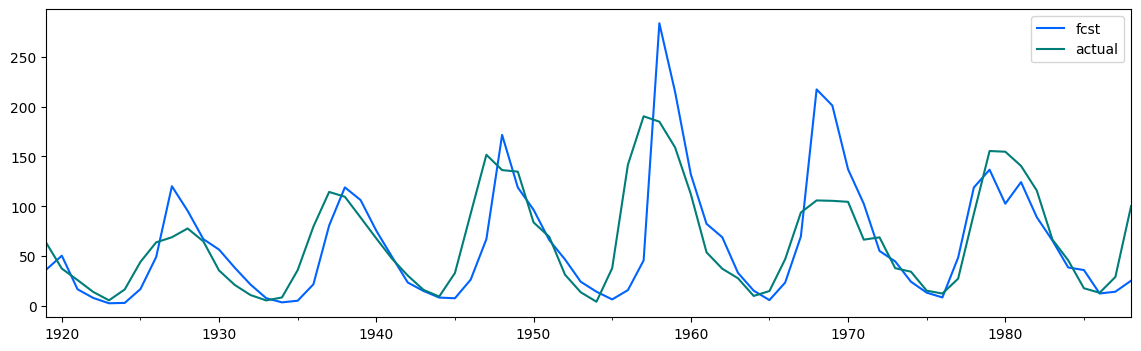

In [84]:
log_cv2.plot()

In [85]:
mape(log_cv2)

0.4137611803062673

# Section 6: Predicting with [Facebook](https://facebookincubator.github.io/prophet/) [Prophet](https://research.fb.com/prophet-forecasting-at-scale/)

From site:

> Today Facebook is open sourcing Prophet, a forecasting tool available in Python and R. The idea is that producing high quality forecasts is not an easy problem for either machines or for most analysts. The models revolves around two main observations in the practice of creating a variety of business forecasts:
- Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate useful assumptions or heuristics.
- Analysts who can produce high quality forecasts are quite rare because forecasting is a specialized data science skill requiring substantial experience.

Prophet is an general additive model that includes a number of highly advanced, intelligent [forecasting methods](http://andrewgelman.com/2017/03/01/facebooks-prophet-uses-stan/), including [changepoint analysis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=0ahUKEwjpwM_JhsbVAhWNxIMKHSWqD6kQFgguMAE&url=http%3A%2F%2Fwww.variation.com%2Fcpa%2Ftech%2Fchangepoint.html&usg=AFQjCNFK6wbwWuBCixZJHu03LkABXL3UHA):


_y = g(t) + s(t) + h(t) + $\epsilon_t$_

Here g(t) is the trend function which models non-periodic changes in the value of the time series, s(t) represents periodic changes (e.g., weekly and yearly seasonality), and h(t) represents the effects of holidays which occur on potentially irregular schedules over
one or more days

- For trend, a piecewise linear or logistic growth curve trend is used. 
    - Prophet automatically detects changes in trends by selecting changepoints from the data.
- For seasonalities, different seasonality components are modeled using Fourier series.
- One can either use fb provided list or incorporate their own holidays into model.


Prophet was originally optimized with the business forecast tasks encountered at Facebook in mind, which typically have any of the following characteristics:

- Hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- Strong multiple “human-scale” seasonalities: day of week and time of year
- Important holidays that occur at irregular intervals that are known in advance
- A reasonable number of missing observations or large outliers
- Historical trend changes, for instance due to product launches or logging changes
- Trends that are non-linear growth curves, where a trend hits a natural limit or saturates


[Technical details behind prophet](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf): built around a generalized additive model (GAM)

In [1]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
# os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)
import warnings
warnings.simplefilter(action='ignore')
import fbprophet
import pmdarima as pm

In [2]:
# read daily page views for the Wikipedia page for Peyton Manning; scraped into hosted CSV
# conda install -c conda-forge fbprophet (to install)
from fbprophet import Prophet
plt.rcParams['figure.figsize'] = [14, 4]

data_path = 'https://raw.githubusercontent.com/PinkWink/DataScience/master/data/07.%20example_wp_peyton_manning.csv'
peyton = pd.read_csv(data_path)

In [3]:
peyton.info()
peyton.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      2905 non-null   object
 1   y       2905 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.5+ KB


ds      y
0  2007-12-10  14629
1  2007-12-11   5012
2  2007-12-12   3582
3  2007-12-13   3205
4  2007-12-14   2680

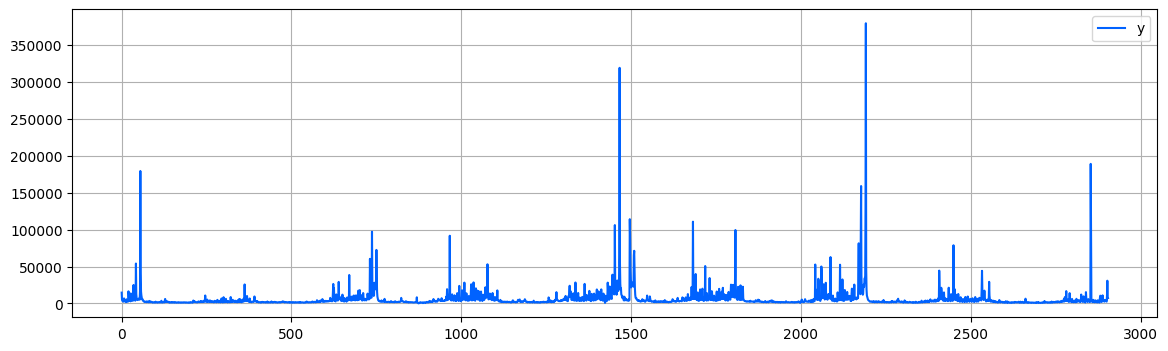

In [4]:
# plot data
peyton.plot()
plt.grid();

In [5]:
# log data due to spikes
# dataframe must have ds column with type datetime and y column which is time series we are trying to predict
peyton['y'] = np.log(peyton['y'])
peyton.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

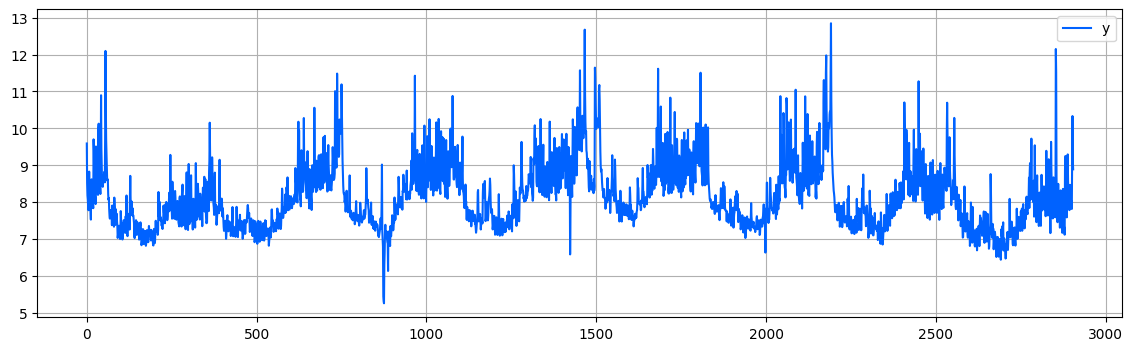

In [6]:
# plot log
peyton.plot()
plt.grid();

In [7]:
# fit model
m = Prophet()
m.fit(peyton)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AttributeError: 'DataFrame' object has no attribute 'append'

In [84]:
peyton.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [85]:
# forecast 365 days into future
# prophet requires a blank dataframe to input predictions
# will also provide blank set for dates within dataset to allow for fit
future = m.make_future_dataframe(periods=365)
print(future.head())
print(future.tail())

          ds
0 2007-12-10
1 2007-12-11
2 2007-12-12
3 2007-12-13
4 2007-12-14
             ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19


In [86]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


ds      yhat  yhat_lower  yhat_upper
3265 2017-01-15  8.208171    7.503198    8.922039
3266 2017-01-16  8.533159    7.753492    9.214067
3267 2017-01-17  8.320549    7.631910    9.061524
3268 2017-01-18  8.153184    7.425827    8.886352
3269 2017-01-19  8.165106    7.441329    8.879306

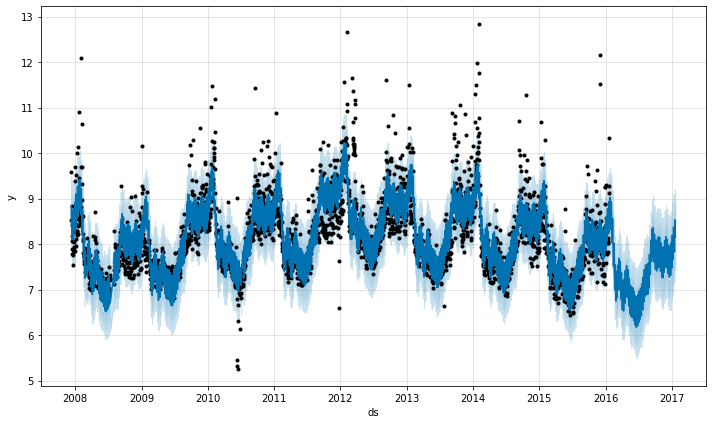

In [87]:
# plot forecast
m.plot(forecast);

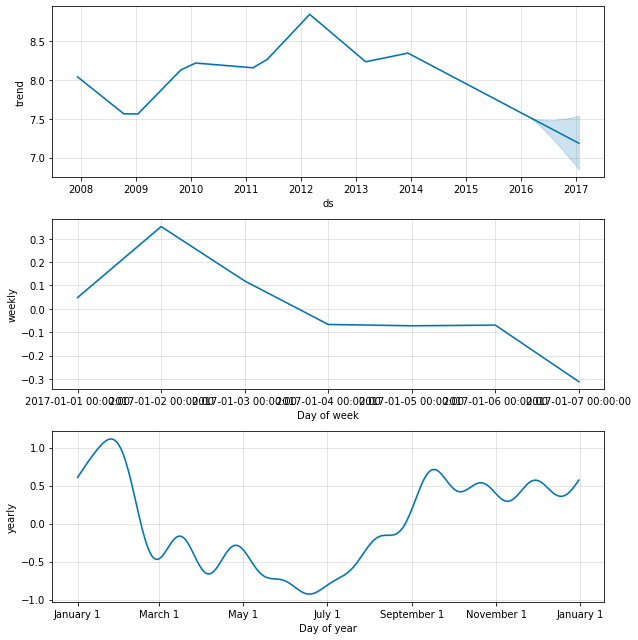

In [88]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
m.plot_components(forecast);

>We can also add holiday and Superbowl date information to Peyton's forecast, since we hypothesize people will visit his site more often on those dates.

In [89]:
# add holidays 
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0, # these help us specify spillover into previous and future days which will be treated as own holidays
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

In [90]:
holidays.head()

holiday         ds  lower_window  upper_window
0  playoff 2008-01-13             0             1
1  playoff 2009-01-03             0             1
2  playoff 2010-01-16             0             1
3  playoff 2010-01-24             0             1
4  playoff 2010-02-07             0             1

In [91]:
# fit and predict
m = Prophet(holidays=holidays)
forecast = m.fit(peyton).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [92]:
# we can see the effects of various 'holidays' on site visits
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

ds   playoff  superbowl
2190 2014-02-02  1.224221   1.203104
2191 2014-02-03  1.898940   1.459895
2532 2015-01-11  1.224221   0.000000
2533 2015-01-12  1.898940   0.000000
2901 2016-01-17  1.224221   0.000000
2902 2016-01-18  1.898940   0.000000
2908 2016-01-24  1.224221   0.000000
2909 2016-01-25  1.898940   0.000000
2922 2016-02-07  1.224221   1.203104
2923 2016-02-08  1.898940   1.459895

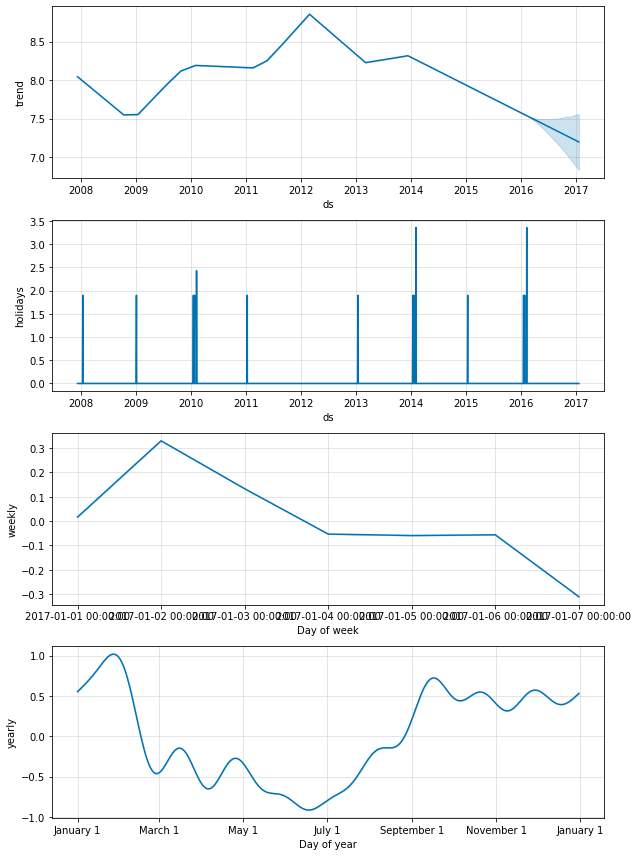

In [93]:
# check the impacts visually
m.plot_components(forecast);

>Peyton won Superbowls XLI (41, 2007) and 50 (2016), while losing XLIV (44, 2010) and XLVIII(48, 2014). We can see these spikes in the holidays chart.

In [94]:
# Add in another seasonality besides yearly, weekly, daily
# fit model
m = Prophet(holidays=holidays,)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(peyton)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
fcst_month = m.predict(future)

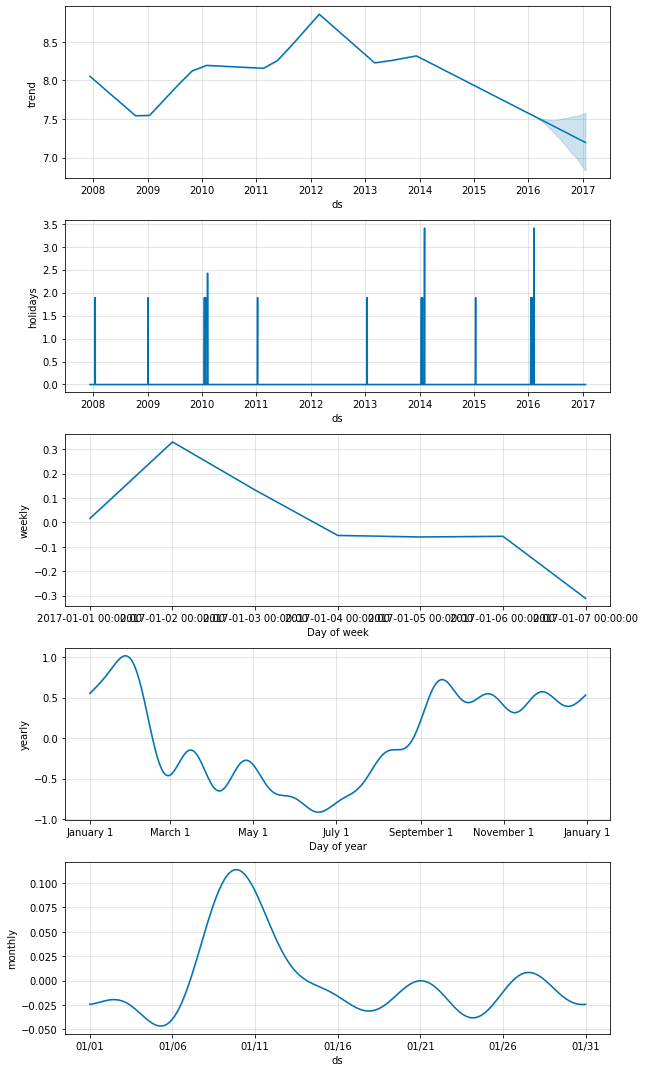

In [96]:
m.plot_components(fcst_month)
plt.show()

# Adding a regressor

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


              ds          y  nfl_sunday
0     2007-12-10   9.590761           0
1     2007-12-11   8.519590           0
2     2007-12-12   8.183677           0
3     2007-12-13   8.072467           0
4     2007-12-14   7.893572           0
...          ...        ...         ...
2900  2016-01-16   7.817223           0
2901  2016-01-17   9.273878           1
2902  2016-01-18  10.333775           0
2903  2016-01-19   9.125871           0
2904  2016-01-20   8.891374           0

[2905 rows x 3 columns]


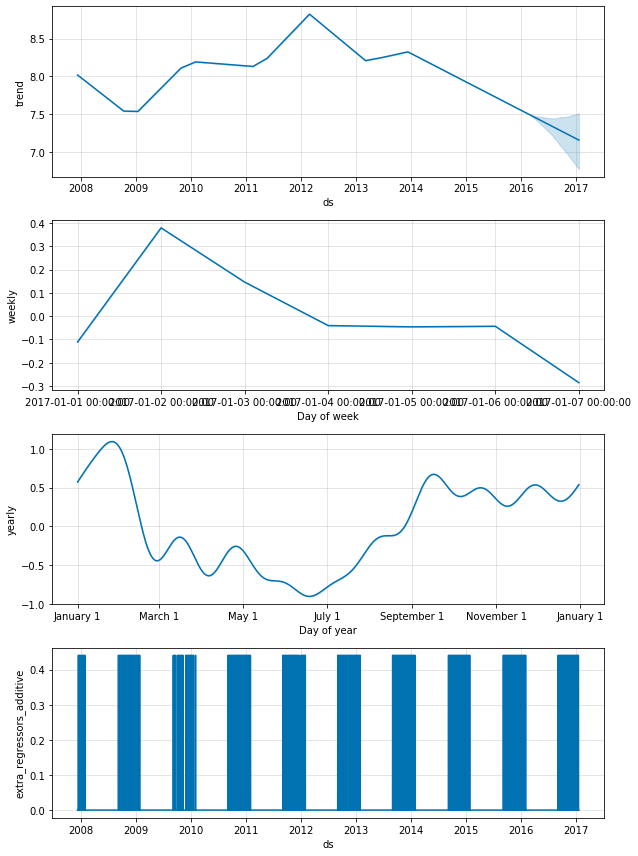

In [97]:
# creating indicator variable for nfl sundays
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
    
#adding that to our df
peyton['nfl_sunday'] = peyton['ds'].apply(nfl_sunday)
print(peyton)

m = Prophet()

# must be in the fit df
m.add_regressor('nfl_sunday')
m.fit(peyton)

# regressor must also be available in future df
future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

In [98]:
# These are points where trend has changed
print('originally: ',m.changepoints[:5])
# you can specify changepoints if you want trend to only be allowed at certain points
m_c = Prophet(changepoints=['2014-01-01'])

print('\nnow: ',m_c.changepoints[:5])

originally:  93    2008-03-17
186   2008-06-20
279   2008-10-11
372   2009-01-14
465   2009-04-17
Name: ds, dtype: datetime64[ns]

now:  DatetimeIndex(['2014-01-01'], dtype='datetime64[ns]', freq=None)


# Cross validation with fbprophet
<img src="data/diagnostics_3_0.png">

In [99]:
from fbprophet.diagnostics import cross_validation
#Starting from 730 days in, making a prediction every 180 days, 365 days into the future
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2010-02-16  8.998933    8.532879    9.482757  8.242493 2010-02-15
1 2010-02-17  8.764575    8.258785    9.284304  8.008033 2010-02-15
2 2010-02-18  8.649843    8.143984    9.148289  8.045268 2010-02-15
3 2010-02-19  8.570880    8.091072    9.030213  7.928766 2010-02-15
4 2010-02-20  8.313209    7.839553    8.817683  7.745003 2010-02-15

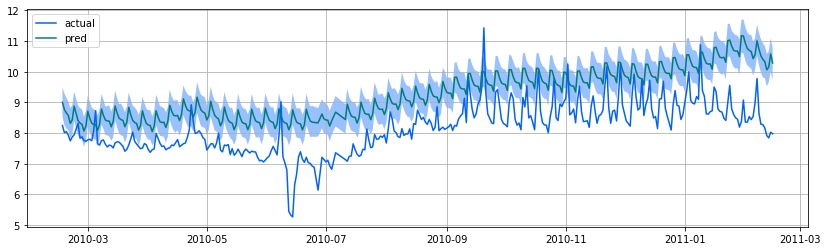

In [100]:
# Just looking at data from first cutoff
first_cut = df_cv[df_cv.cutoff == datetime(2010,2,15)]
plt.plot(first_cut.ds,first_cut.y,label='actual')
plt.plot(first_cut.ds,first_cut.yhat,label = 'pred')
plt.fill_between(first_cut.ds,first_cut.yhat_lower,first_cut.yhat_upper,alpha=0.4)
plt.grid()
plt.legend()

In [101]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape  coverage
0 37 days  0.494728  0.703369  0.506860  0.058717  0.666514
1 38 days  0.499801  0.706966  0.510718  0.059151  0.665372
2 39 days  0.522379  0.722758  0.517344  0.059815  0.662631
3 40 days  0.529516  0.727679  0.519364  0.060029  0.661261
4 41 days  0.534146  0.730853  0.518587  0.059902  0.668799

### Predicting CO2

In [102]:
# load data
co2 = pd.read_csv('./co2-ppm-mauna-loa-19651980.csv', 
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)
co2 = co2.drop('idx', 1)

# recast co2 col to float
co2['co2'] = pd.to_numeric(co2['co2'])
co2.drop(labels=0, inplace=True)

# set index
index = pd.date_range('1/1/1965', periods=191, freq='M')
co2.index = index

In [103]:
# load co2 data, rename headers, and check
# data = sm.datasets.co2.load_pandas()
# co2 = data.data

co2['ds'] = co2.index
co2.rename(columns={'co2': 'y'}, inplace=True)

co2.tail()

y         ds
1980-07-31  337.19 1980-07-31
1980-08-31  335.49 1980-08-31
1980-09-30  336.63 1980-09-30
1980-10-31  337.74 1980-10-31
1980-11-30  338.36 1980-11-30

In [104]:
# fit model
model = Prophet()
model.fit(co2);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [105]:
# forecast 15 years into future
future = model.make_future_dataframe(periods=120, freq='M', include_history=True)
future.tail()

#future = model.make_future_dataframe(periods=365*15)
#future.tail()

ds
306 1990-07-31
307 1990-08-31
308 1990-09-30
309 1990-10-31
310 1990-11-30

In [106]:
# populate forecast
forecast = model.predict(future)
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
306 1990-07-31  354.924971  335.607648  370.380483   336.769191   371.471783   
307 1990-08-31  355.063263  333.919260  368.933589   336.610682   371.921462   
308 1990-09-30  355.197093  333.431875  369.218141   336.460935   372.322623   
309 1990-10-31  355.335385  334.254718  370.809356   336.313187   372.623899   
310 1990-11-30  355.469215  335.230407  372.129528   336.179776   372.967186   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
306       -1.117225             -1.117225             -1.117225 -1.117225   
307       -2.908550             -2.908550             -2.908550 -2.908550   
308       -3.146657             -3.146657             -3.146657 -3.146657   
309       -2.000587             -2.000587             -2.000587 -2.000587   
310       -0.940856             -0.940856             -0.940856 -0.940856   

     yearly_lower  yearly_upper  multiplicative_terms  \
306     -1.117225     -1.117225                   0.0   
307     -2.908550     -2.908550                   0.0   
308     -3.146657     -3.146657                   0.0   
309     -2.000587     -2.000587                   0.0   
310     -0.940856     -0.940856                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
306                         0.0                         0.0  353.807746  
307                         0.0                         0.0  352.154712  
308                         0.0                         0.0  352.050436  
309                         0.0                         0.0  353.334798  
310                         0.0                         0.0  354.528359

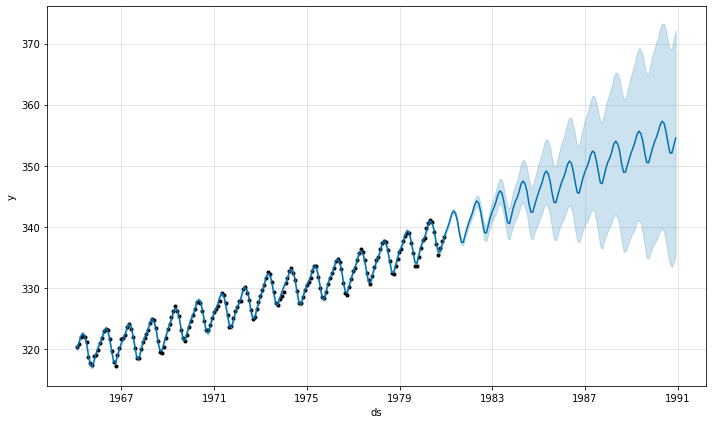

In [107]:
model.plot(forecast);

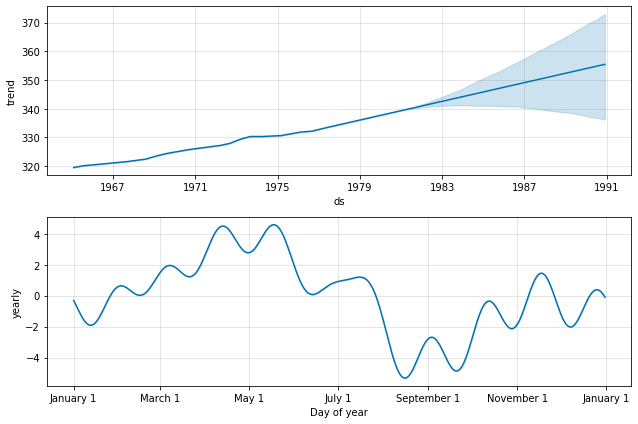

In [108]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
model.plot_components(forecast);

# Things to look into adjusting

In [109]:
# Decreasted drastically from defaults
changepoint_prior_scale = 0.05
seasonality_prior_scale = 0.00001

growth='logistic'

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


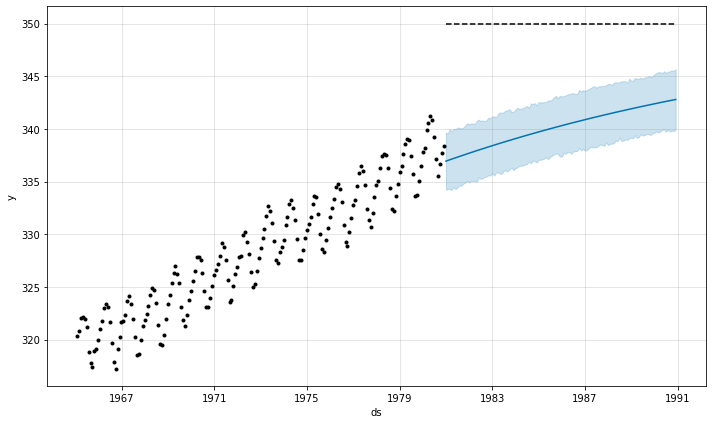

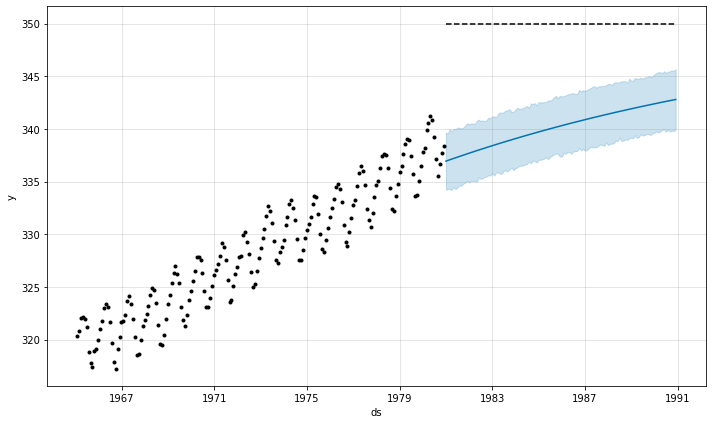

In [110]:
# we can add a cap to limit our theoretical growth if we are using logistic growth
co2['cap'] = 350
m = Prophet(growth=growth, #weekly_seasonality=10000,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(co2);

# forecast 15 years into future with cap of 380
future = m.make_future_dataframe(periods=120,freq='M', include_history=False)
future['cap'] = 350

forecast = m.predict(future)
m.plot(forecast)

# Exercise
* Create prediction using hourly data of PM_Dongsi for last day half of december of 2015
    * Note you will have to use what we first learned to convert the year, month, day, hour columns to datetime object
* Plot daily and weekly seasonality of forecast

In [111]:
df_Beijing = pd.read_csv('./FiveCitiesPM/Beijing.csv')
df_Beijing.head()

No  year  month  day  hour  season  PM_Dongsi  PM_Dongsihuan  \
0   1  2010      1    1     0       4        NaN            NaN   
1   2  2010      1    1     1       4        NaN            NaN   
2   3  2010      1    1     2       4        NaN            NaN   
3   4  2010      1    1     3       4        NaN            NaN   
4   5  2010      1    1     4       4        NaN            NaN   

   PM_Nongzhanguan  PM_US Post  DEWP  HUMI    PRES  TEMP cbwd    Iws  \
0              NaN         NaN -21.0  43.0  1021.0 -11.0   NW   1.79   
1              NaN         NaN -21.0  47.0  1020.0 -12.0   NW   4.92   
2              NaN         NaN -21.0  43.0  1019.0 -11.0   NW   6.71   
3              NaN         NaN -21.0  55.0  1019.0 -14.0   NW   9.84   
4              NaN         NaN -20.0  51.0  1018.0 -12.0   NW  12.97   

   precipitation  Iprec  
0            0.0    0.0  
1            0.0    0.0  
2            0.0    0.0  
3            0.0    0.0  
4            0.0    0.0

In [112]:
# Instructor solution
# Create a new column that is a datetime object
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])

df_Beijing['date'] = df_Beijing.apply(make_date,axis=1)
# Make index for easy indexing of time values

df_Beijing.set_index('date',inplace=True)
df_Beijing['ds'] = df_Beijing.index

# Only take required fields
df = df_Beijing[["ds",'PM_Dongsi']]
df.rename(columns = {'PM_Dongsi':'y'},inplace=True)

# create a training set and a test set. We are only going to use last month's data to make everything a bit more clear
df_train = df['2015-11']
df_test = df['2015-12':'2015-12-15']
print(df_train.tail())
print(df_test.tail())

                                     ds      y
date                                          
2015-11-30 19:00:00 2015-11-30 19:00:00  685.0
2015-11-30 20:00:00 2015-11-30 20:00:00  685.0
2015-11-30 21:00:00 2015-11-30 21:00:00  638.0
2015-11-30 22:00:00 2015-11-30 22:00:00  548.0
2015-11-30 23:00:00 2015-11-30 23:00:00  490.0
                                     ds    y
date                                        
2015-12-15 19:00:00 2015-12-15 19:00:00  9.0
2015-12-15 20:00:00 2015-12-15 20:00:00  7.0
2015-12-15 21:00:00 2015-12-15 21:00:00  6.0
2015-12-15 22:00:00 2015-12-15 22:00:00  4.0
2015-12-15 23:00:00 2015-12-15 23:00:00  6.0


In [113]:
# fit model
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [114]:
future = m.make_future_dataframe(periods = 15*24,freq = 'h') # could also leave default freq of days and do 31 for period
print(future.head())
future.tail()

                   ds
0 2015-11-01 00:00:00
1 2015-11-01 01:00:00
2 2015-11-01 02:00:00
3 2015-11-01 03:00:00
4 2015-11-01 04:00:00


ds
1075 2015-12-15 19:00:00
1076 2015-12-15 20:00:00
1077 2015-12-15 21:00:00
1078 2015-12-15 22:00:00
1079 2015-12-15 23:00:00

In [115]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


ds         yhat   yhat_lower   yhat_upper
1075 2015-12-15 19:00:00  1361.302132  1073.065506  1634.896592
1076 2015-12-15 20:00:00  1363.598920  1081.769522  1648.047760
1077 2015-12-15 21:00:00  1362.396483  1073.093923  1648.953237
1078 2015-12-15 22:00:00  1359.504008  1076.761574  1646.262377
1079 2015-12-15 23:00:00  1356.114245  1057.776719  1632.299111

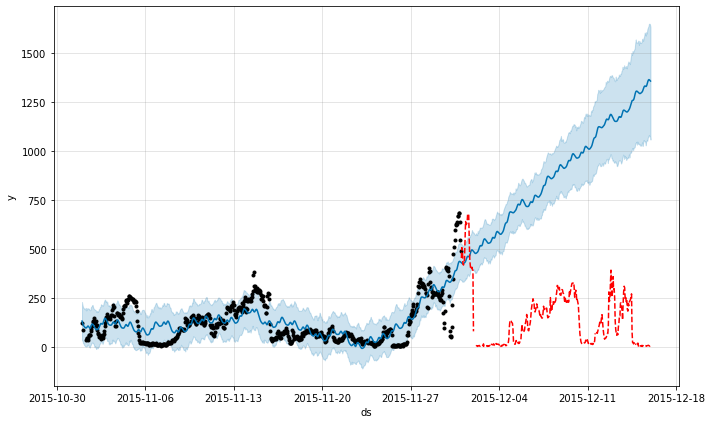

In [116]:
m.plot(forecast)
plt.plot(df_test.y,'r--')

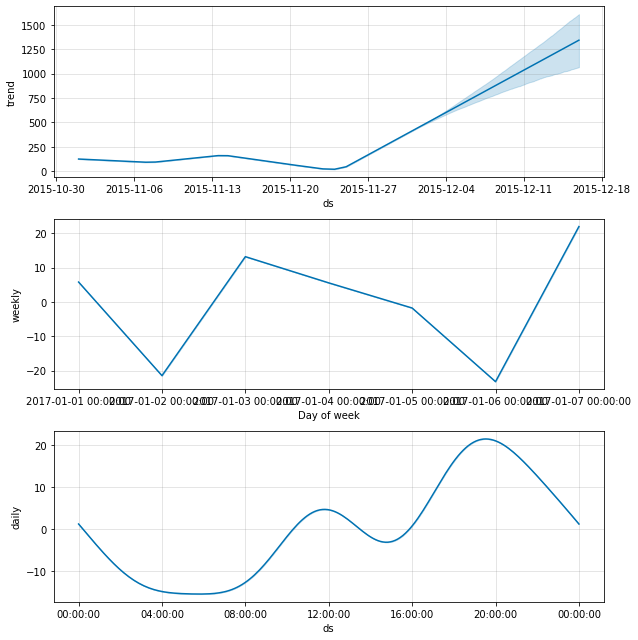

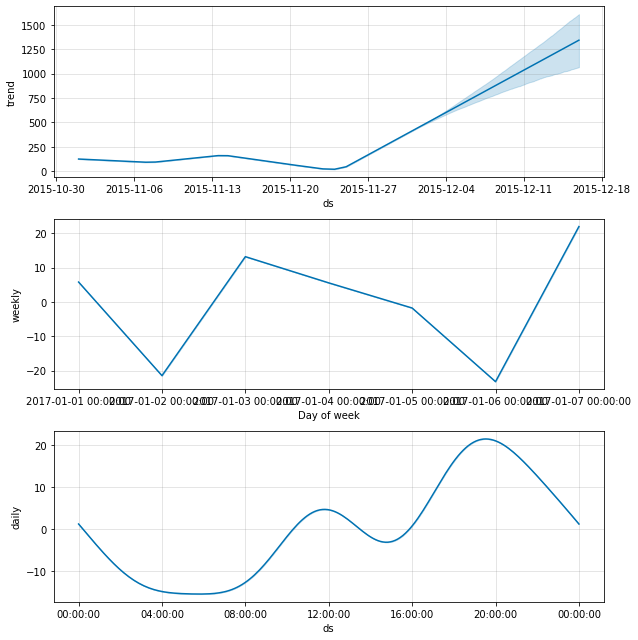

In [117]:
m.plot_components(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


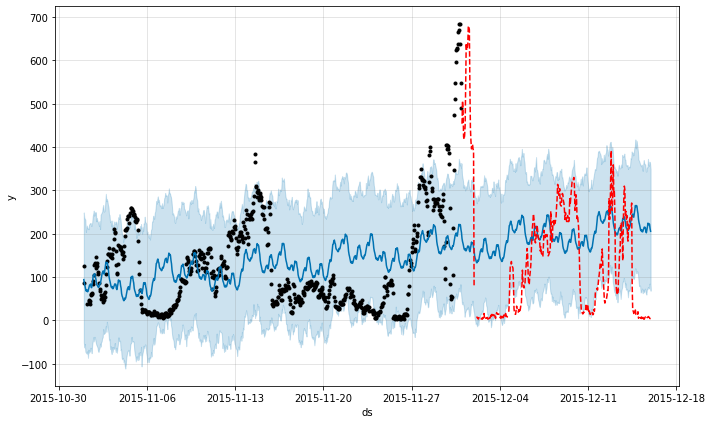

In [118]:
# Decreasted drastically from defaults
changepoint_prior_scale = 0.0005
seasonality_prior_scale = 10


m = Prophet(daily_seasonality=10,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(df_train);


forecast = m.predict(future)
m.plot(forecast)
plt.plot(df_test.y,'r--')

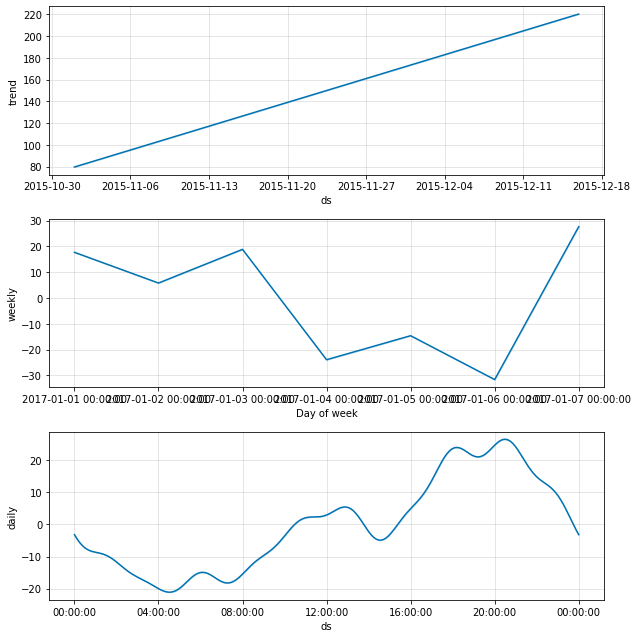

In [119]:
m.plot_components(forecast);

---

# Summary
In this notebook, we have covered: 
1. A practical understanding of Autoregressive Moving Average (ARMA) models.
2. A basic understanding of the Autocorrelation Function (ACF).
3. Insight into choosing the order *q* of MA models.
4. A practical understanding of Autoregressive (AR) models.
5. A basic understanding of the Partial Autocorrelation Function (PACF).
6. Insight into choosing the order *p* of AR models.



---
### Machine Learning Foundation (C) 2020 IBM Corporation